In [125]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import labtools.statistics

In [2]:
# set (local) path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/ampaim/'
mpath = '/tmp/sshfs/ampaim/'

In [3]:
# global functions
def rename_df(df, col):
    pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SjD'),('healthy','Healthy')]
    for p in pairs:
        df[col] = df[col].replace(p[0],p[1])
    return df

##### Process Mapping Files and Metadata #####

In [4]:
###
# Load AB mapping file
###

# get AMPAIM+EISER mapping file w metadata; drop row 1
df_map_AB = pd.read_csv(path + 'inputs/adamcantor22_Cross_Disease_Pilot_0/Qiime2_0/qiime_mapping_file.tsv', sep='\t', header=0, index_col=0)

# get first row for any future operations
first_row = df_map_AB.reset_index().iloc[0,]
first_row_df = pd.DataFrame(first_row).T
df_map_AB = df_map_AB.iloc[1:,]


###
# Specific replacements
###

# 526-0-twin-psaplate308 is missing a dash
df_map_AB = df_map_AB.rename(index={'526-0-twin-psaplate308': '526-0-twin-psa-plate308'})

###
# General replacements
###

# refrain from dropping NA's because you might need the columns for Q2 and you need to smoothly concat the first row

# convert index to str from float etc.
df_map_AB.index = df_map_AB.index.map(str)

# switch EISER diagnosis to eiser from NA
df_map_AB.loc[df_map_AB['Project'] == 'eiser', 'Diagnosis'] = 'eiser'

# RBB mapping file doesn't have info on duplicate controls, and the glass control info is extracted only from a subset of the names
# so we need to grab that info from AB's mapping file
samp_to_ctrlstatus = df_map_AB['Project'].to_dict()

# grab AB non-microteach samples
df_map_AB_filt = df_map_AB[df_map_AB['Project'].isin(['eiser','TWIN_PSA','glass_control','neg_control','duplicate_control'])]

df_map_AB_filt.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,StudyType,SubjectType,BirthYear,HostSubjectId,Nationality,Sex,SpecimenType,UberonCodeType,Weight,WeightDateCollected
#SampleID,,,,,,,,,,,,,,,,,,,,,
116783-plate305,CCTCGCATGACC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116783,NaN,NaN,fecal,NaN,NaN,NaN
116784-plate305,CGCGCAAGTATT,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116784,NaN,NaN,fecal,NaN,NaN,NaN
116785-plate305,AAGGCGCTCCTT,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116785,NaN,NaN,fecal,NaN,NaN,NaN
116786-plate305,CGCAATGAGGGA,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116786,NaN,NaN,fecal,NaN,NaN,NaN
116787-plate305,ACGGCGTTATGT,CCGGACTACHVGGGTWTCTAAT,E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,NaN,116787,NaN,NaN,fecal,NaN,NaN,NaN


In [5]:
###
# Prepare for merge with RB mapping file
###

# load RB mapping file
df_map_RB = pd.read_csv(path + 'inputs/qiime_mapping_file_final_062123_RBB_ESR_CRPmod.csv', index_col=0)

# skip row with q2types; 140 columns
df_map_RB = df_map_RB.iloc[1:,]

# exclude unaffected since we are using TWINS_PSA from AB and controls from AB
# we only want microteach samples
df_map_RB = df_map_RB[df_map_RB['Diagnosis'].isin(['healthy','ss','sle','cd','RA','psa','pso'])]

# drop duplicate samples that appear in AB and that are controls per AB mapping file
for s in list(df_map_RB.index.values):
    if samp_to_ctrlstatus[s] in ['glass_control','duplicate_control','neg_control']:
        df_map_RB = df_map_RB.drop(s)
        
        
# merge with AB
df_meta = pd.concat([df_map_AB_filt, df_map_RB], axis=0)

# drop 'Separate' and 'Together'; presumably Q2 artifacts
df_meta = df_meta.drop(['Separate','Together'], axis=1)

# add in Project col from AB that describes controls
df_meta['Project'] = df_meta.index.map(samp_to_ctrlstatus)

###
# Specific replacements
###

# replace HxOtherDMARDs
df_meta.loc['540-0-twin-psa-plate308','HxOtherDMARDs'] = 'N'

### 
# General replacements
###

# specify float cols for later
float_cols = ['Age','BSA','CRP','DAS28','ESR','PhysicianGlobalPsA','RAPID3','SJC','TJC']

# Replace Y,N with 1,0 
df_meta = df_meta.replace({'Y':1,'N':0})

### 
# Create new mapping files
### 

def export_q2(df, first_row_df):
    df_q2 = df.reset_index()
    df_q2 = pd.concat([first_row_df, df_q2])
    df_q2 = df_q2.set_index('#SampleID')
    df_q2.loc['#q2:types',:] = 'categorical'
    df_q2 = df_q2.reset_index()
    return df_q2

# (1) filter out controls
df_meta = df_meta[df_meta['Project'].isin(['eiser','microteach','TWIN_PSA'])]

# (2) filter out treatments
# drop TWIN PSA and PSO samples that have treatment on biologics, DMARDS, MTX
drop_samples = ['275-psa-plate307', '475-psa-plate307', '542-0-twin-psa-plate308']
df_meta = df_meta.drop(drop_samples)

# remove samples that are treated other than above
drops = []
for v in ['CurrentBiologics', 'CurrentOtherDMARDs', 'CurrentMTX', 'HxOtherDMARDs']:
    df = df_meta[df_meta[v].isin(['Y',1])]
    drops = drops + list(df.index.values)

df_meta = df_meta.drop(drops)
print('Dropped this many samples: ' + str(len(drops)))

# drop eiser samples from downstream analysis
df_meta = df_meta[df_meta['Diagnosis'] != 'eiser']

# drop CD 
df_meta = df_meta[df_meta['Diagnosis'] != 'cd']

# drop unaffected twins
df_meta = df_meta[df_meta['Diagnosis'] != 'unaffected']

# export to Q2
df_meta_q2 = export_q2(df_meta, first_row_df)
df_meta_q2.to_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser_nocd.tsv', sep='\t', index=False, na_rep='nan') 



###
# Pre-processing
###

df_meta['Diagnosis'].value_counts()

Dropped this many samples: 18


Diagnosis
RA         41
psa        27
pso        25
healthy     6
ss          5
sle         4
Name: count, dtype: int64

In [6]:
# merge CDP and MSQ141 MMEDs qiime mapping files
# load CDP
df_cdp = pd.read_csv(path + 'inputs/qiime_mapping_file_noctrl_noeiser_nocd.tsv', sep='\t')
df_cdp['Batch'] = 'CDP'

# load MSQ141
df_141 = pd.read_csv(path + 'inputs/qiime_mapping_file_MSQ141.tsv', sep='\t')

# rename Age at Visit to Age
df_141.columns = df_141.columns.map(lambda x: x.replace('AgeAtVisit','Age') )

# drop row 0 (#q2types) prior to merge
df_141 = df_141.iloc[1:,:]
df_141['Batch'] = 'MSQ141'

# add in diagnosis column that is IllnessNotes to all lowercase
df_141['Diagnosis'] = df_141['IllnessNotes'].apply(lambda x: x.lower())

# replace sjd with ss and psa_pso with psa
df_141['Diagnosis'] = df_141['Diagnosis'].replace('sjd','SjD')
df_141['Diagnosis'] = df_141['Diagnosis'].replace('psa_pso','psa')
df_141['Diagnosis'] = df_141['Diagnosis'].replace('ra','RA')

# replace specific samples
df_141 = df_141.set_index('#SampleID')
# TBD
#df_141 = df_141.drop('703.019.stamp.plate313') # myasthenia gravis
#df_141.loc['702.013.stamp.plate313','Diagnosis'] = 'RA'
#df_141.loc['702.014.stamp.plate313','Diagnosis'] == 'SjD'
df_141 = df_141.reset_index()

# export
df_141_q2 = export_q2(df_141, first_row_df)
#df_141_q2.to_csv(path + 'inputs/qiime_mapping_file_MSQ141_fixdiag.tsv', sep='\t', index=False, na_rep='nan') 

# merge rows
df_merge = pd.concat([df_cdp, df_141])#, axis=1)
df_merge = df_merge.set_index('#SampleID')
df_merge.loc['#q2:types',:] = 'categorical'

# note that lots of reasons might exist for batch effect, like treatment, also different diseases
# columns are not consistent (e.g. IllnessNotes in MSQ141 vs Diagnosis in CDP)
df_merge.to_csv(path + 'inputs/qiime_mapping_file_batch_nocd.tsv', sep='\t')

# standard binarize column for each medication
# convert from float
df_merge['Medication'] = df_merge['Medication'].astype(str)


# grab all medications
meds = list(df_merge['Medication'].values)

# drop 'categorical'
meds.remove('categorical')

uniq_meds = []
# split items with '_'
for m in meds:
    if '_' in m:
        items = m.split('_')
        items = [i.lower() for i in items]
        uniq_meds = uniq_meds + items
    else:
        uniq_meds.append(m.lower())
    
uniq_meds = list(set(list(uniq_meds)))
print(uniq_meds)

# create new column for each med
for u in uniq_meds:
    df_merge[u] = 0
    df_merge.loc[0,u] = 'categorical'

# iterate through each sample
for index, row in df_merge.iterrows():
    if index != 0: # the whole '#q2:types', 'categorical' thing
        medications = df_merge.loc[index,'Medication'].lower()
        medications = medications.split('_')
        for m in medications:    
            df_merge.loc[index,m] = 1

# new mapping file with med columns
df_merge = df_merge.drop(0)

# create involvement
def classify_psa(type):
    if type == 'peripheral':
        return 'peripheral'
    elif type == 'mixed' or type == 'axial': 
        return 'axial'
    else:
        return np.nan

df_merge['Involvement'] = df_merge['PsAtype'].apply(lambda x: classify_psa(x))

# create dict mapping diagnosis to samples
diag_to_samp = {}
for d in list(set(df_meta['Diagnosis'].values)):
    diag_to_samp[d] = list(df_meta[df_meta['Diagnosis'] == d].index.values)


# create copy df meta for nss and ss
df_meta = df_merge.copy()
df_meta = df_meta.drop('#q2:types')

# create df_merge that is a holder prior to filtering
df_merge_q2 = df_merge.copy()
df_merge_q2.loc['#q2:types',:] = 'categorical'
df_merge_q2 = df_merge_q2[df_merge_q2['Diagnosis'].isin(['non-sjogrens sicca','ss','categorical'])]
df_merge_q2['Diagnosis'] = df_merge_q2['Diagnosis'].replace('non-sjogrens sicca','nss')
df_merge_q2 = df_merge_q2.reset_index()
df_merge_q2.to_csv(path + 'inputs/qiime_mapping_file_merge_nss_ss.tsv', sep='\t', index=False, na_rep='nan')

# create copy df meta
df_merge_q2.loc['#q2:types',:] = 'categorical'
df_merge_q2.to_csv(path + 'inputs/qiime_mapping_file_merge_meds.tsv', sep='\t', index=False, na_rep='nan')

df_merge_q2.head()

['nan', 'topicals', 'leflunomide', 'mtx', 'hcq', 'nomed', 'prednisone']


,#SampleID,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,...,DiseaseActive,nan,topicals,leflunomide,mtx,hcq,nomed,prednisone,categorical,Involvement
0,#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
1,769-slesjo-plate308,CGGGACACCCGA,CCGGACTACHVGGGTWTCTAAT,C2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
2,2771-slesjo-plate308,ACCTTACACCTT,CCGGACTACHVGGGTWTCTAAT,D2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
3,2948-slesjo-plate308,GTAGTAGACCAT,CCGGACTACHVGGGTWTCTAAT,E2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
4,131-slesjo-plate308,CCGGACAAGAAG,CCGGACTACHVGGGTWTCTAAT,F2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN


In [7]:
# disease breakdown by sample numbers
df_141_q2['IllnessNotes'].value_counts()

IllnessNotes
Non-Sjogrens sicca    12
SjD                    5
PsO                    3
RA                     2
categorical            1
SLE                    1
PsA_PsO                1
Name: count, dtype: int64

##### Alpha Diversity #####

KruskalResult(statistic=0.0173913043478251, pvalue=0.8950822971464321)


Diagnosis
NSS    12
SjD    10
Name: count, dtype: int64

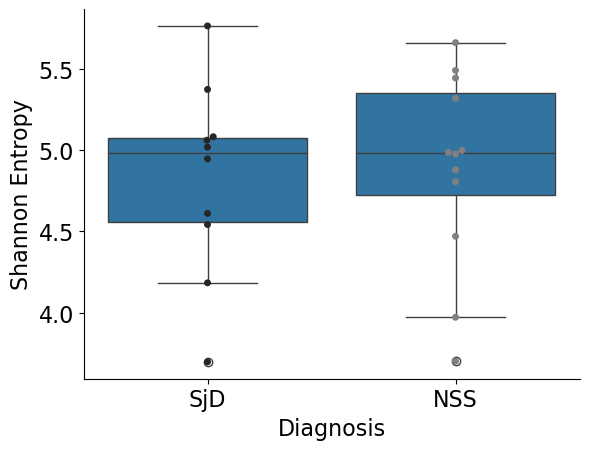

In [8]:
# plot nicer alpha div
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# convert NSS to SICCA
pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SjD'),('healthy','Healthy')]     
for p in pairs:
    df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace(p[0],p[1])
    
# subset on NSS SS
df_alpha = df_alpha[df_alpha['Diagnosis'].isin(['NSS','SjD'])]

# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Diagnosis",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.Diagnosis.value_counts()


KruskalResult(statistic=1.4309146850868046, pvalue=0.23161521940339191)


Diagnosis
RA                    43
pso                   28
psa                   28
non-sjogrens sicca    12
ss                    10
healthy                6
sle                    5
Name: count, dtype: int64

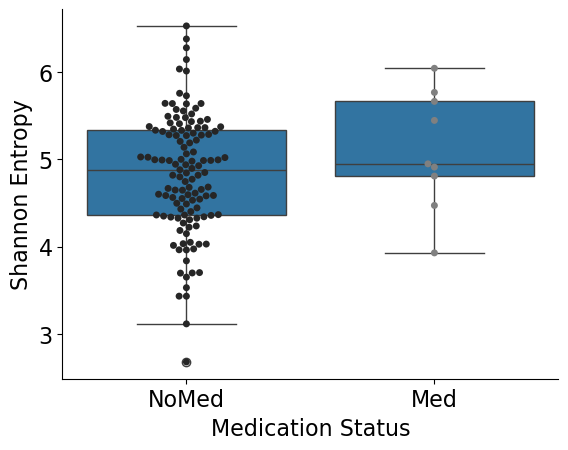

In [9]:
# plot medication alpha div
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# merge AgeAtVisit and Age
df_alpha['Age'] = df_alpha['Age'].fillna(df_alpha['AgeAtVisit'])

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# create new column based off of Medication column
df_med = df_alpha.copy()
df_med = pd.concat([df_meta[['mtx','hcq','Weight','CurrentBiologics','CurrentOtherDMARDs','HxOtherDMARDs','Ethnicity']], df_med], axis=1)

# subset based on relevant meds
# df_med = df_med[df_med['Medication'].isin(['NoMed','HCQ_prednisone','MTX','MTX_HCQ','Prednisone_MTX_Leflunomide'])] 
for x in ['mtx','CurrentBiologics','CurrentOtherDMARDs','HxBiologics','HxOtherDMARDs','hcq']:
    df_med[x] = df_med[x].astype(float)
    
df_med['sum'] = df_med[['mtx','CurrentBiologics','CurrentOtherDMARDs','HxBiologics','HxOtherDMARDs','hcq']].sum(axis=1)

#for m in ['HCQ', 'MTX', 'NoMed']:
#    df_med[m] = df_med['Medication'].apply(lambda x: 1 if m in x else 0)

# convert medication into binary
# df_med['Medication'] = df_med['Medication'].apply(lambda x: 'NoMed' if x == 'NoMed' else 'Med')
df_med['Medication_Status'] = df_med['sum'].apply(lambda x: 'Med' if x > 0 else 'NoMed')
df_med['Medication_Status2'] = df_med['sum'].apply(lambda x: 'Treated' if x > 0 else 'Untreated')

# df_med['Medication'] = df_med.apply(lambda row: 'NoMed' if row['Medication_Status'] == 'NoMed' else row['Medication'], axis=1)
                                                         
# export for R
df_med.to_csv(path + 'inputs/df_med.tsv', sep='\t')

# KW test
print(scipy.stats.kruskal(*list(df_med.groupby('Medication_Status')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_med, x='Medication_Status', y='shannon_entropy')
sns.swarmplot(data=df_med, x='Medication_Status', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Medication Status",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.Diagnosis.value_counts()


KruskalResult(statistic=12.0904820568486, pvalue=0.05998043490265998)
132


Diagnosis
RA         43
PsO        28
PsA        28
NSS        12
SjD        10
Healthy     6
SLE         5
Name: count, dtype: int64

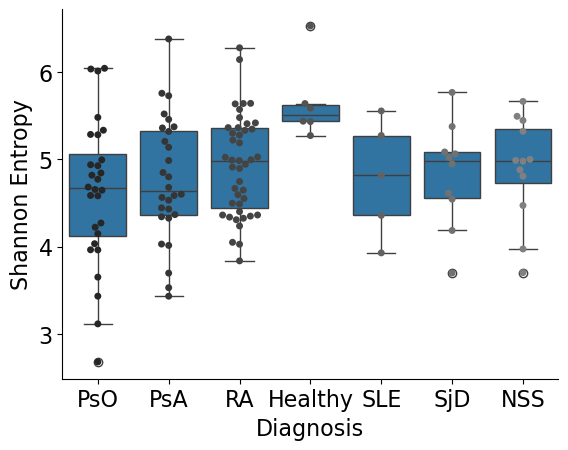

In [11]:
# plot nicer alpha div
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# convert NSS to SICCA

# rename
pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SjD'),('healthy','Healthy')]     
for p in pairs:
    df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace(p[0],p[1])


# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Diagnosis",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.to_csv(path + 'outputs/jobs27/df_alpha.tsv', sep='\t')
print(len(df_alpha))
df_alpha.Diagnosis.value_counts()


##### Table 1 #####

In [10]:
# for table 1 for presentation
t1_meta = ['BSA',
       'BSASeverityByBSA', 'CCPtiter', 'CRP', 'CurrentBiologics',
       'CurrentIntralesionalSteroids', 'CurrentMTX', 'CurrentMTXdose',
       'CurrentOtherDMARDs', 'CurrentParenteralSteroids',
       'CurrentTopicalSteroids', 'CurrentUV', 'DAS28', 'Dactylitis',
       'DaysSinceExperimentStart', 'Diagnosis', 'DiseaseDuration',
       'DrugNaive', 'ESR', 'Enthesitis', 'HLAB27',
       'Hispanic', 'HxBiologics', 'HxOtherDMARDs', 'MDHAQ',
       'PhysicianGlobalPsA', 'Plate',
       'ProbioticsInPast1mo', 'ProbioticsInPast3Months', 'Project',
        'RAPID3', 'RFtiter', 'Race', 'SJC','TJC','Ethnicity','Age','Sex','Weight','CCPpos',
       'Disease', 'DiseaseDurationYears', 'RFpos',
       'EverTreated', 'Medication', 'DiseaseActive',
       'AgeAtVisit', 'hcq', 'topicals', 'mtx', 'nomed',
       'prednisone', 'Involvement']

# df = df_med[t1_meta]

t1_meta = ['Age','Sex','Weight','Diagnosis','Medication','Hispanic','Race','mtx', 
           'Ethnicity','CurrentBiologics','CurrentOtherDMARDs','HxBiologics','HxOtherDMARDs',
           'hcq','Medication_Status']
# df_med['Medication_Status'].value_counts()

# filter on relevant metadata vars
df_t1 = df_med[t1_meta]

# drop col that are all na
df_t1 = df_t1.dropna(axis=1, how='all')
 
# create a new column that is a mix of Race and Hispanic, where everything is to lower
# black_white is black
# white and hispanic -> hispanic
# white and not hispanic -> caucasian 
df_t1['Race'] = df_t1['Race'].replace(np.nan,'nan')
df_t1['Race'] = df_t1['Race'].apply(lambda x: x.lower())
df_t1['Race'] = df_t1['Race'].replace('black_white','nan')

# new function to label per row
def label_race(row):
   if row['Hispanic'] == '1.0':
      return 'hispanic'
   else:
       return row['Race']

df_t1['Final_Ethnicity'] = df_t1.apply(label_race, axis=1)

# rename dx
df_t1 = rename_df(df_t1, 'Diagnosis')

df = df_t1.copy()

# order of variables will be
'''
n
Age (years)
Sex (M/F)
Ethnicity
Hispanic
Caucasian
Black
Asian
Medication (Y/N)
MTX
HCQ
Other DMARDs
Current Biologics
Hx of Biologics
Hx of Other DMARDs
'''

ns = []
ages = []
genders = []
#sex_F = []
#sex_M = []
# sex_order = ['F','M']
# ethnicities = []
# ethnicity_order = ['hispanic','caucasian','black','asian']
ethnicity_hispanic = [] 
ethnicity_caucasian = [] 
ethnicity_black = []
ethnicity_asian = []

medications = []
med_order = ['mtx','hcq','CurrentOtherDmards','CurrentBiologics','HxBiologics','HxOtherDMARDs']

# for every column in table 1 (i.e. healthy, affected, then each disease individually)
dfs = {
    'Healthy': 'placeholder',
    'Affected': df_t1[df_t1['Diagnosis'] != 'Healthy']
}

# sets order in table
dx = ['Healthy', 'RA', 'PsO', 'PsA', 'SLE', 'SjD', 'NSS']

for d in dx:
    dfs[d] = df_t1[df_t1['Diagnosis'] == d]

col_vals = {}

for d in dfs:
    print(d)
    col_entries = [d]

    # grab relevant df
    df = dfs[d]

    # get n samp
    n = len(df)    
    ns.append(n)
    col_entries.append(n)
    
    # for continuous vars, get a CI
    for f in ['Age']:
        X = df[f].astype(float)
        
        # drop na
        X = X.dropna()

        # get mean age
        confidence_level = 0.95
        mean = np.round(np.nanmean(X),1)

        sem = scipy.stats.sem(X)
        ci = scipy.stats.t.interval(confidence_level, len(X) - 1, loc=mean, scale=sem)
        str_ci = str(mean) + ' (' + str(np.round(ci[0],1)) + ', ' + str(np.round(ci[1],1)) + ')'

        # mean age and sd
        if np.isnan(sem):
            str_age = str(mean) + ' (NA)'
        else:
            str_age = str(mean) + ' (' + str(np.round(sem,1)) + ')'
        col_entries.append(str_age)
        #if np.isnan(mean): 
        #    col_entries.append('NA')
        #elif np.isnan(ci[0]):           
        #    col_entries.append(str(mean) + ' (NA, NA)')
        #else:            
        #    ages.append(str_ci)
        #    col_entries.append(str_ci)


    # sex_order = ['F','M']
    n_F, n_M = len(df[df['Sex'] == 'F']),len(df[df['Sex'] == 'M'])
    gender_percent = int(np.round(n_F / (n_F + n_M)*100, 0))
    gender_str = str(len(df[df['Sex'] == 'F'])) + ' (' + str(gender_percent) + '%)'  
    
    # genders.append(gender_tuple)
    col_entries.append(gender_str)

    # add title
    col_entries.append('')

    # get n per ethnicity
    for e in ['hispanic', 'white', 'black', 'asian']:
        sub_df = df.dropna(how='any', subset='Final_Ethnicity')
        
        n_e = len(sub_df[sub_df['Final_Ethnicity'] == e])
        n_total = len(sub_df)

        eth_percent = int(np.round(n_e / (n_total)*100, 0))
        eth_str = str(n_e) + ' (' + str(eth_percent) + '%)'  
        col_entries.append(eth_str)

    # 
    # ethnicity_order = ['hispanic','caucasian','black','asian']
    # gemder_tuple
    ethnicities = []
    medications = []
    col_entries.append('')
    # med_order = ['mtx','hcq','CurrentOtherDMARDs','CurrentBiologics','HxBiologics','HxOtherDMARDs']
    med_order = ['mtx','hcq','HxBiologics']
    for m in med_order:
        sub_df = df.dropna(how='any', subset=m)

        n_m = len(sub_df[sub_df[m] == 1])
        n_total = len(sub_df)

        if n_total == 0:
            col_entries.append('NA')

        else:
            med_percent = int(np.round(n_m / (n_total)*100, 0))
            med_str = str(n_m) + ' (' + str(med_percent) + '%)'  

            col_entries.append(med_str)

    
    # for categorical vars, get a value_counts
    #for f in ['Diagnosis','CurrentBiologics']: #,'Diagnosis', 'Ethnicity', 'Medication']
    #    print(df[f].value_counts(dropna=False))

    # each column is: Diagnosis, n, Age, Gender_tuple, Ethnicity(title), Hispanic, Caucasian, Black, Asian, Medication (title), then med order
    col_vals[d] = col_entries

df_final_t1 = pd.DataFrame.from_dict(col_vals)
df_final_t1.index = ['Diagnosis', 'n', 'Age (s.d.)', 'Female (%)', 'Ethnicity', 'Hispanic', 'Caucasian', 'Black', 'Asian',
                     'Medication', 'MTX','HCQ','HxBiologics']

df_final_t1.to_csv(path + 'outputs/jobs27/df_final_t1.csv')
df_final_t1


Healthy
Affected
RA
PsO
PsA
SLE
SjD
NSS


,Healthy,Affected,RA,PsO,PsA,SLE,SjD,NSS
Diagnosis,Healthy,Affected,RA,PsO,PsA,SLE,SjD,NSS
n,6,126,43,28,28,5,10,12
Age (s.d.),43.0 (1.9),47.7 (1.2),46.8 (2.0),49.2 (2.2),44.6 (2.5),32.0 (NA),49.4 (5.4),54.4 (3.7)
Female (%),4 (67%),92 (73%),37 (86%),17 (61%),11 (39%),5 (100%),10 (100%),12 (100%)
Ethnicity,,,,,,,,
Hispanic,2 (33%),38 (30%),26 (60%),2 (7%),9 (32%),1 (20%),0 (0%),0 (0%)
Caucasian,2 (33%),68 (54%),7 (16%),25 (89%),16 (57%),1 (20%),7 (70%),12 (100%)
Black,0 (0%),7 (6%),5 (12%),0 (0%),0 (0%),2 (40%),0 (0%),0 (0%)
Asian,2 (33%),10 (8%),4 (9%),0 (0%),3 (11%),1 (20%),2 (20%),0 (0%)
Medication,,,,,,,,


##### Beta Div #####

In [12]:
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
df_pc = df_pc.set_index('131-slesjo-plate308') 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['131-slesjo-plate308'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_meta, df_med], axis=1)

# rename
pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SjD'),('healthy','Healthy')]
for p in pairs:
    df_pc['Diagnosis'] = df_pc['Diagnosis'].replace(p[0],p[1])

df_pc.to_csv(path + 'outputs/jobs27/unweighted_pcoa.tsv', sep='\t')
df_pc.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,RFpos,Batch,EverTreated,Medication,DiseaseActive,AgeAtVisit,shannon_entropy,sum,Medication_Status,Medication_Status2
209-pso-plate307,0.062894,-0.047001,-0.003304,-0.055587,0.08124,0.070976,0.00132,-0.050877,-0.013162,-0.023986,...,NaN,CDP,NaN,NaN,NaN,NaN,4.841988,0.0,NoMed,Untreated
235-psa-plate307,0.092096,-0.074027,-0.004846,0.089962,-0.072339,-0.085908,-0.053861,-0.11416,0.04784,0.091376,...,NaN,CDP,NaN,NaN,NaN,NaN,3.696383,0.0,NoMed,Untreated
240-psa-plate307,0.124884,-0.057131,-0.014148,-0.085413,-0.020368,-0.001142,-0.072633,-0.106414,-0.005917,0.039714,...,NaN,CDP,NaN,NaN,NaN,NaN,3.530011,0.0,NoMed,Untreated
241-pso-plate307,-0.07952,0.003158,0.152208,0.134782,0.077693,0.019814,0.059889,-0.018681,0.001654,-0.058065,...,NaN,CDP,NaN,NaN,NaN,NaN,3.115866,0.0,NoMed,Untreated
260-pso-plate307,-0.022745,0.235147,-0.103778,-0.030971,0.091113,-0.037331,-0.116086,-0.030346,-0.055308,0.047916,...,NaN,CDP,NaN,NaN,NaN,NaN,4.924878,0.0,NoMed,Untreated


In [13]:
df_merge.Diagnosis.value_counts()

Diagnosis
RA                    43
psa                   28
pso                   28
non-sjogrens sicca    12
healthy                6
ss                     5
sle                    5
SjD                    5
categorical            1
Name: count, dtype: int64

##### AIMD specific mapping files, prepped for LEfSe #####

In [14]:
### Loop for all LEfSe
# for LEfSe, jobs00, aggregate
# pairs, [<list of group 1> <list of group 2>]
### Loop for all LEfSe
# for LEfSe, jobs00, aggregate
# pairs, [<list of group 1> <list of group 2> <aggregate group 2>]
comp_to_groups = {
    'AvH': (['healthy'],['psa','pso','SjD','sle','RA', 'NSS'],['Affected']), # healthy vs disease aggregate, jobs03
    'RAvH': (['healthy'],['RA'],['RA']), # jobs04 
    'PsOvH': (['healthy'],['pso'],['pso']), #jobs05
    'PsAvH': (['healthy'],['psa'],['psa']), #jobs05
    'SjDvH': (['healthy'],['SjD'],['SjD']), #jobs06
    'SICCAvH': (['healthy'],['non-sjogrens sicca'],['non-sjogrens sicca']), #jobs06
    'SLEvH': (['healthy'],['sle'],['sle'])
}

for c in comp_to_groups:
    # unpack tuples
    healthy, disease, aggregate = comp_to_groups[c]
    
    # subset relevant diseases
    df_meta_XvH = df_merge[df_merge['Diagnosis'].isin(healthy + disease)]
    
    # change all diseases to aggregate string
    df_meta_XvH.loc[df_meta_XvH['Diagnosis'].isin(disease), 'Diagnosis'] = aggregate[0]

    # add first row
    df_meta_XvH = df_meta_XvH.reset_index()
    df_meta_XvH = pd.concat([first_row_df, df_meta_XvH])
    df_meta_XvH = df_meta_XvH.set_index('#SampleID')
    df_meta_XvH.loc["#q2:types",:] = 'categorical' 

    # export to csv
    df_meta_XvH.to_csv(path + 'inputs/qiime_mapping_file_merge_' + c + '.tsv', sep='\t', na_rep='nan')
    df_meta_XvH.head()

df_meta_XvH.head()

,BarcodeSequence,LinkerPrimerSequence,AmpliconWell,BSA,BSASeverityByBSA,CCPtiter,CRP,CurrentBiologics,CurrentIntralesionalSteroids,CurrentMTX,...,DiseaseActive,nan,topicals,leflunomide,mtx,hcq,nomed,prednisone,categorical,Involvement
#SampleID,,,,,,,,,,,,,,,,,,,,,
#q2:types,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,...,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical,categorical
SCFA08-B-plate308,AGCCTTCGTCGC,CCGGACTACHVGGGTWTCTAAT,A1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
MicraHC-1017-B-plate308,CGTATAAATGCG,CCGGACTACHVGGGTWTCTAAT,B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
MicraHC-1018-B-plate308,TGACTAATGGCC,CCGGACTACHVGGGTWTCTAAT,C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN
MicraHC-1019-B-plate308,GTGGAGTCTCAT,CCGGACTACHVGGGTWTCTAAT,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,0,0,0,0,0,NaN,NaN


##### PiCRUSt2 #####

In [15]:
# PICRUST2
# don't forget to uncompress path_abun_unstrat.tsv.gz
# 393 columns/pathways represented here
df_fxn = pd.read_csv(path + 'outputs/jobs06/picrust2_out/KO_metagenome_out/pred_metagenome_unstrat_kegg.tsv', sep='\t', index_col=0).T
KO_names = list(df_fxn.columns.values)

# normalize by row total (per sample basis)
df_fxn = df_fxn.div(df_fxn.sum(axis=1), axis=0)
# df_fxn.to_csv(path + 'inputs/df_pathways.tsv', sep='\t')

# new metadata for concatenation
# df_meta_sample = df_meta.set_index('SampleID')

# concatenate
# df_pi = pd.concat([df_meta_sample, df_fxn], axis=1)
# df_pi.head()

#gene names; KO is just a placeholder
# KO_names = [x for x in df_pi.columns.values if x[0] == 'K']
# KO_names = [x for x in df_pi.columns.values if x[-3:] == 'PWY']

# RA first
# df_KO = df_pi[df_pi['Diagnosis'].isin(['healthy','RA'])]#'pso','psa'])]
# df_KO = df_KO[KO_names + ['Diagnosis']]

# subset
# df_ra_KO = df_KO[df_KO['Diagnosis'].isin(['RA'])]#'pso','psa'])]
# df_healthy_KO = df_KO[df_KO['Diagnosis'].isin(['healthy'])]
df_fxn.to_csv(path + 'inputs/df_fxn.tsv', sep='\t', index_label='SampleID')

df_fxn.head()

KEGG_Pathway,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - ganglio series,Genetic Information Processing|Transcription|Spliceosome,Human Diseases|Infectious disease: bacterial|Bacterial invasion of epithelial cells,Human Diseases|Infectious disease: bacterial|Yersinia infection,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Cellular Processes|Cellular community - eukaryotes|Signaling pathways regulating pluripotency of stem cells,Environmental Information Processing|Signal transduction|Plant hormone signal transduction,Metabolism|Biosynthesis of other secondary metabolites|Caffeine metabolism,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids
131-slesjo-plate308,0.154241,0.032859,0.002144,0.002534,0.008080,0.000207,0.028834,0.000208,0.025778,0.000018,...,0.000034,1.778871e-07,0.000012,0.000006,0.000000e+00,0.0,7.891717e-07,0.0,4.851465e-07,0.0
209-pso-plate307,0.162486,0.036005,0.002162,0.002779,0.008271,0.000198,0.029178,0.000239,0.027246,0.000020,...,0.000073,0.000000e+00,0.000007,0.000004,0.000000e+00,0.0,0.000000e+00,0.0,2.290513e-06,0.0
235-psa-plate307,0.160321,0.037601,0.002473,0.002860,0.008970,0.000229,0.028518,0.000201,0.027689,0.000010,...,0.000051,0.000000e+00,0.000002,0.000000,0.000000e+00,0.0,0.000000e+00,0.0,9.551294e-07,0.0
240-psa-plate307,0.160501,0.035443,0.002249,0.002794,0.008322,0.000169,0.028757,0.000183,0.026960,0.000014,...,0.000078,1.077469e-07,0.000000,0.000000,0.000000e+00,0.0,7.973273e-07,0.0,3.124661e-06,0.0
241-pso-plate307,0.157769,0.026655,0.002151,0.003115,0.007333,0.000134,0.031393,0.000208,0.026847,0.000002,...,0.000004,6.877063e-08,0.000010,0.000006,6.877063e-07,0.0,0.000000e+00,0.0,1.203486e-07,0.0


##### Taxa tables #####

In [16]:
# unnormalized OTU table level-6 also has metadata in it! nice 
# from taxa_bar_plot.qzv
L_to_otu = {}
levels = [3,6,7]
L_to_spec_otu = {}
# build dict of otu tables
for l in levels:
    # construct key
    level = 'L' + str(l)

    # read in df otu
    df_otu = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/level-' + str(l) + '.csv', index_col=0)
    
    # determine columns to drop; i.e. keep taxa only
    dropcol = []
    for c in list(df_otu.columns.values):
        if c[0:3] != 'd__':
            dropcol.append(c)
            
    # keep Diagnosis for later
    keepcol = df_otu['Diagnosis']
    
    df_otu = df_otu.drop(dropcol, axis=1)
    df_otu.to_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/counts_L' + str(l) + '.csv')
    
    # normalize the cols
    df_otu = df_otu.div(df_otu.sum(axis=1), axis=0)
    df_otu.to_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/otu_table_L' + str(l) + '.csv')

    # merge clostridia
    clost = []
    for x in df_otu.columns:
        if 'clostr' in x:
            clost.append(x)

    df_otu['Clostridium'] = df_otu.loc[:,clost].sum(axis=1)
    
    # take taxa of interest
    # d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A
    # d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125
    # d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri
    taxa = {}
    taxa['L3'] = []
    taxa['L6'] = ['d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A',
                  'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125',
                  'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Coprobacteraceae;g__Coprobacter',
                 'Clostridium',
                  'd__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia',
                  'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia',
                  'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium'] 

    
    taxa['L7'] = ['d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri']
    renamed = {}
    renamed['L3'] = []
    renamed['L6'] = ['Phascolarctobacterium', 'Anaerotignum', 'Coprobacter', 'Clostridium', 'Akkermansia', 'Roseburia','Faecalibacterium']
    renamed['L7'] = ['Prevotella_copri']
    
    df_otu_spec = df_otu.loc[:,taxa['L' + str(l)]]
    df_otu_spec.columns = renamed['L' + str(l)]
    
    # reappend dx
    df_otu = pd.concat([df_otu, df_meta.loc[:,['BSA','CRP','ESR','SJC','TJC','Diagnosis']]],axis=1)
    df_otu = rename_df(df_otu, 'Diagnosis')
    df_otu.to_csv(path + 'inputs/otu_table_L' + str(l) + '_meta.csv')

    # add to dict 
    L_to_otu[level] = df_otu
    df_otu_spec = pd.concat([df_otu_spec, df_meta.loc[:,['BSA','CRP','ESR','SJC','TJC','Diagnosis']]],axis=1)    
    df_otu_spec = rename_df(df_otu_spec, 'Diagnosis')
    L_to_spec_otu[level] = df_otu_spec

df = pd.concat([L_to_spec_otu['L6'].loc[:,renamed['L6']], L_to_spec_otu['L7']], axis=1)

# df.to_csv(path + 'inputs/df_otu_meta_logt.csv')
# df.to_csv(path + 'inputs/df_otu_meta.csv')

# rename
df = pd.concat([df, df_fxn[['Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis',
                           'Metabolism|Carbohydrate metabolism|Butanoate metabolism',
                           'Metabolism|Carbohydrate metabolism|Propanoate metabolism']]], axis=1)
df = df.rename(columns={'Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis':'Mannose_Biosynthesis',
                        'Metabolism|Carbohydrate metabolism|Butanoate metabolism': 'Butanoate_Metabolism',
                        'Metabolism|Carbohydrate metabolism|Propanoate metabolism': 'Propanoate_Metabolism'})

# create col for dx yes no
df['DiagnosisAIMD'] = df['Diagnosis'].map(lambda x: 'Healthy' if x == 'Healthy' else 'AIMD')

# save non log transformed
df.to_csv(path + 'inputs/df_otu_meta_fxn.csv')

# log transform 
v_to_min = {}
vars = ['Phascolarctobacterium', 'Coprobacter','CRP','Clostridium','Mannose_Biosynthesis', 'Akkermansia', 'Roseburia','Faecalibacterium']
for var in vars:
    df[var] = df[var].astype(float)
    v_to_min[var] = np.min(df[df[var] != 0][var])
    df['log' + '(' + var + ')'] = df[var].apply(lambda x: np.log(x + v_to_min[var]/2))
    df['log' + var] = df[var].apply(lambda x: np.log(x + v_to_min[var]/2))


df = pd.concat([df, df_alpha['shannon_entropy']], axis=1)

df.to_csv(path + 'inputs/df_otu_meta_fxn_logt.csv')
df.head()

,Phascolarctobacterium,Anaerotignum,Coprobacter,Clostridium,Akkermansia,Roseburia,Faecalibacterium,Prevotella_copri,BSA,CRP,...,logClostridium,log(Mannose_Biosynthesis),logMannose_Biosynthesis,log(Akkermansia),logAkkermansia,log(Roseburia),logRoseburia,log(Faecalibacterium),logFaecalibacterium,shannon_entropy
131-slesjo-plate308,0.000000,0.000000,0.0,0.006220,0.114119,0.050744,0.012599,0.000000,NaN,NaN,...,-5.078210,-21.282052,-21.282052,-2.170431,-2.170431,-2.979560,-2.979560,-4.372631,-4.372631,5.060604
209-pso-plate307,0.022813,0.000264,0.0,0.000923,0.000000,0.000308,0.099209,0.000000,3,NaN,...,-6.975952,-21.282052,-21.282052,-11.555698,-11.555698,-7.878771,-7.878771,-2.310335,-2.310335,4.841988
235-psa-plate307,0.000000,0.004882,0.0,0.021295,0.243498,0.004798,0.000000,0.000000,3,NaN,...,-3.848790,-21.282052,-21.282052,-1.412607,-1.412607,-5.324953,-5.324953,-10.859537,-10.859537,3.696383
240-psa-plate307,0.008384,0.000000,0.0,0.008688,0.076671,0.000457,0.040317,0.000000,13,NaN,...,-4.744506,-21.282052,-21.282052,-2.568107,-2.568107,-7.545869,-7.545869,-3.210504,-3.210504,3.530011
241-pso-plate307,0.001458,0.000000,0.0,0.002089,0.000000,0.000552,0.000197,0.000039,7,NaN,...,-6.165779,-21.282052,-21.282052,-11.555698,-11.555698,-7.381223,-7.381223,-8.438828,-8.438828,3.115866


##### Pathways Phas CRP correlations #####

In [18]:
# per disease correlation CRP with Phas
df = pd.read_csv(path + 'inputs/df_otu_meta_fxn.csv', index_col=0)

# indiv vars
fa = ['Butanoate_Metabolism', 'Mannose_Biosynthesis']#,
      #'Metabolism|Carbohydrate metabolism|Propanoate metabolism',
      #'Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis']
cyto = ['CRP']#,'ESR','BSA']
bact = ['Phascolarctobacterium', 'Coprobacter', 'Clostridium']

# merge vars
vars = fa + cyto + bact

df_corr = df.loc[:,vars]

for d in list(df.Diagnosis.unique()) + ['Affected']:
    print(d)
    if d == 'Affected':
        sub = df[df['Diagnosis'] != 'Healthy']
    else:
        sub = df[df['Diagnosis'] == d]
    
    for i, x in enumerate(vars):
        for j in range(i):
            y = vars[j]
            try:
                r, p = scipy.stats.spearmanr(sub[x],sub[y],nan_policy='omit')            
                #if p < 0.3:
                print(x,y)
                print(r,p)
            
                plt.figure(figsize=(3,3))
                sns.lmplot(data=sub,x=x,y=y)
                sns.despine()
                plt.tight_layout()
                plt.savefig(path + 'outputs/jobs27/corrs/' + d + '_' + x + '_' + y + '.pdf')
                plt.close()
            except ValueError:
                continue





SjD
Mannose_Biosynthesis Butanoate_Metabolism
-0.40618119722996154 0.2441286818964912
CRP Butanoate_Metabolism
nan nan
CRP Mannose_Biosynthesis
nan nan
Phascolarctobacterium Butanoate_Metabolism
0.4165011326193405 0.2311834603669827
Phascolarctobacterium Mannose_Biosynthesis
-0.2614881801842454 0.46552763473625547
Phascolarctobacterium CRP
nan nan
Coprobacter Butanoate_Metabolism
nan nan
Coprobacter Mannose_Biosynthesis
nan nan
Coprobacter CRP
nan nan
Coprobacter Phascolarctobacterium
nan nan
Clostridium Butanoate_Metabolism
-0.05454545454545454 0.8810361811618526
Clostridium Mannose_Biosynthesis
0.058025885318565944 0.8734948923712951
Clostridium CRP
nan nan
Clostridium Phascolarctobacterium
0.3004270464795243 0.39898780712414983
Clostridium Coprobacter
nan nan
PsO
Mannose_Biosynthesis Butanoate_Metabolism
0.018882334492874 0.9240218961837878
CRP Butanoate_Metabolism
-1.0 0.0
CRP Mannose_Biosynthesis
-0.8660254037844387 0.3333333333333332
Phascolarctobacterium Butanoate_Metabolism
-0.

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [19]:
for x in (L_to_otu['L7'].columns.values):
    if 'Anaerotignum' in x:
        print(x)
    if 'Phascolarctobacterium' in x:
        print(x)
    if 'copri' in x:
        print(x)

d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri
d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A;s__Phascolarctobacterium_A sp900545025
d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A;s__Phascolarctobacterium_A faecium
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125;__
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125;s__Anaerotignum lactatifermentans
d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A;__
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189163;s__Anaerotignum aminivorans


##### DMM #####

In [20]:
# First go to R and run the DMM script to generate the cluster assignments and scores
#df_dmm = pd.read_csv(path + 'outputs/visualizations_dir_nyu/dmm_lplc_relabd_assign.tsv', sep='\t', index_col=0)
# df_dmm = pd.read_csv(path + 'outputs/jobs19/dmm_lplc_relabd_assign.tsv', sep='\t', index_col=0)
# df_final = pd.concat([df_meta, df_dmm], axis=1)
# df_final.index.name = '#SampleID'

# export for rerun Q2
# df_disease = export_q2(df_final, first_row_df)
# df_disease.to_csv(path + 'inputs/qiime_mapping_file_psara_dmm.tsv', sep='\t', index=False, na_rep='nan')

# assess chi square GOF
# df_final = df_final.dropna(axis='rows', subset=['Diagnosis'])

df_final = pd.read_csv(path + 'inputs/qiime_mapping_file_psara_dmm.tsv', sep='\t')
df_final = df_final.iloc[1:,:]
df_final = df_final.dropna(axis='rows', subset=['Diagnosis'])

# new col for SJ TJC binary
df_final['TJCpos'] = df_final['TJC'].map(lambda x: 1 if float(x) > 0 else 0)
df_final['SJCpos'] = df_final['SJC'].map(lambda x: 1 if float(x) > 0 else 0)

# DMM GROUPING
dmm = [int(float(x)) for x in df_final['dmm.grp'].values]
diag = df_final['Diagnosis'].values

# disease_grouping only exists if we grouped RA and PsA etc.
for col in ['Diagnosis']: # ,'disease_grouping_1','disease_grouping_2']:
    diag = df_final[col].values
    for d in list(set(diag)):
        y = np.array([0 if x == d else 1 for x in diag])
        x,p = scipy.stats.chisquare(f_obs=[dmm, y], axis=None)#, f_exp=None, ddof=0, axis=0)
        #if p<0.05:
        print(col)
        print(d)
        print(p)
print('Done')


Diagnosis
healthy
1.0
Diagnosis
pso
1.0
Diagnosis
sle
1.0
Diagnosis
psa
1.0
Diagnosis
non-sjogrens sicca
1.0
Diagnosis
RA
1.0
Diagnosis
ss
1.0
Done


##### LEfSe merging #####

In [21]:
# combine LEfSe results
# all files are lefse_table.tsv
# add 10 for L7 results, L6 is listed below
'''
outputs/
	jobs11							# LEfSe for PsAvH
	jobs10							# LEfSe for PsOvH
    jobs16                          # AvH
    jobs09                          # RAvH
    jobs12                          # SSvH
    jobs13                          # SLEvH
    jobs15                          # SS+SLE aka SSSLEvH        
    jobs14                          # NSS
'''
# create dict mapping diagnosis to lefse results
# start w/ two disease for play testing
# eventually can consider the enriched in H set, but start with enriched in diseased set
diag_to_lefse = {}
diag_to_path = {}
diag_to_lefse_disease = {}
diag_to_lefse_healthy = {}
for l in ['L6', 'L7']:
    diag_to_lefse_disease[l] = {
        'PsA': [],
        'PsO': [],
        #'A': [],
        'RA': [],
        'SS': [],
        'SLE': [],
        # 'SSSLE': [],
        'NSS': [],
    }
    diag_to_lefse_healthy[l] = {
        'PsA': [],
        'PsO': [],
        #'A': [],
        'RA': [],
        'SS': [],
        'SLE': [],
        # 'SSSLE': [],
        'NSS': [],
    }

diag_to_path['L6'] ={
    'PsA': 'outputs/jobs11/',
    'PsO': 'outputs/jobs10/',
    #'A': 'outputs/jobs16/',
    'RA': 'outputs/jobs09/',
    'SS': 'outputs/jobs12/',
    'SLE': 'outputs/jobs13/',
    'NSS': 'outputs/jobs14/',
    # 'SSSLE': 'outputs/jobs15/',
}
diag_to_path['L7'] ={
    'PsA': 'outputs/jobs21/',
    'PsO': 'outputs/jobs20/',
    #'A': 'outputs/jobs26/',
    'RA': 'outputs/jobs19/',
    'SS': 'outputs/jobs22/',
    'SLE': 'outputs/jobs23/',
    'NSS': 'outputs/jobs24/',
    # 'SSSLE': 'outputs/jobs25/',
}

# counter dicts per level
L_to_count = {}
from collections import defaultdict

# '' is disease, otherwise healthy
for l in ['L6','L7']:
    L_to_count[l] = {}
    for h in ['healthy_','']:
        L_to_count[l][h] = defaultdict()
        
        # common to all
        print(h)
        for diag in diag_to_path[l]:        
            # import df, rename columns
            df_lefse = pd.read_csv(path + diag_to_path[l][diag] + 'lefse_results.res', sep='\t', header=None)    
            df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
            
            # replace dash with nan, cast to float
            df_lefse = df_lefse.replace('-', np.nan)
            df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
            
            # get sig results and results pertaining to enriched group
            df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
            if h == 'healthy_':
                df_lefse = df_lefse[df_lefse['Enriched_Group'] == 'healthy']
            else:
                df_lefse = df_lefse[df_lefse['Enriched_Group'] != 'healthy']
            
            # drop na
            df_lefse = df_lefse.dropna()
            
            print(diag)
            print(len(df_lefse))
            if h == '':
                print(df_lefse.Taxa.values)

            for taxa in df_lefse.Taxa.values:
                if taxa in L_to_count[l][h]:
                    L_to_count[l][h][taxa] += 1
                else:
                    L_to_count[l][h][taxa] = 1
                
            if diag == 'PsA':
                shared = set(df_lefse['Taxa'].values)
            else:
                shared = shared.intersection(set(df_lefse['Taxa'].values))
            
            #df_lefse = df_lefse.sort_values('Effect_Size')
            df_lefse.to_csv(path + 'outputs/jobs04/' + l + '_' + diag + '_lefse_' + h + 'sig.tsv', sep='\t')
            if h == 'healthy_':
                diag_to_lefse_healthy[l][diag] = list(df_lefse['Taxa'].values)
            else:            
                diag_to_lefse_disease[l][diag] = list(df_lefse['Taxa'].values)
    
        print(shared)
# convert to df for output file to R
# summary_df = pd.Dataframe()
# summary_df = pd.DataFrame.from_dict(diag_to_lefse)
# summary_df




healthy_
PsA
64
PsO
54
RA
39
SS
26
SLE
14
NSS
23
{'d__Bacteria.p__Firmicutes_C.c__Negativicutes.o__Acidaminococcales.f__Acidaminococcaceae.g__Phascolarctobacterium_A'}

PsA
1
['d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ']
PsO
1
['d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Oscillospirales.f__CAG_272.g__QALR01']
RA
1
['d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Prevotella']
SS
2
['d__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Oscillospirales.f__Oscillospiraceae_88309.g__Lawsonibacter'
 'd__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Lachnospirales.f__Lachnospiraceae.g__Clostridium_Q_134516']
SLE
3
['d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ'
 'd__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Peptostreptococcales.f__Anaerovoracaceae.__'
 'd__Bacteria.p__Firmicutes_A.c__Clostridia_258483.o__Lachnospirales.f__Lach

###### Cytoscape ######

In [22]:
# network comparison
# jobs28
# pval0.05--ampaim_cytoscape_5e2.txt_4 default node.csv
# comparison healthy vs disease
phas = 'd__Bacteria.p__Firmicutes_C.c__Negativicutes.o__Acidaminococcales.f__Acidaminococcaceae.g__Phascolarctobacterium_A'.replace('.',';')

l_to_df = {}
for l in ['healthy', 'disease', 'disease0', 'disease1', 'disease2']:
    df = pd.read_csv(path + 'outputs/jobs28/' + l + '.csv')
    l_to_df[l] = df
    print(l)
    print(len(df))
    # print(df[df['OTU_id']==phas])

for m in df.columns.values:
    print(m)
    try:
        f, p = scipy.stats.f_oneway(*[df[m] for df in list(l_to_df.values())])
        print(f,p)
        
        values = []
        categories = []
        for l in l_to_df:
            df = l_to_df[l]
            categories.extend([l] * len(df[m]))
            values.extend(df[m])
    
        df_plot = pd.DataFrame({'cat':categories,'vals':values})
        
        plt.figure(figsize=(6,4))
        sns.barplot(data=df_plot, x='cat', y='vals')
        # sns.swarmplot(data=df_plot, x='cat', y='vals',color='gray')
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/jobs28/plots/' + m + '.pdf') 
        plt.close()
    except:
        print('pass')


healthy
239
disease
408
disease0
402
disease1
398
disease2
401
abundance
3.5932085662969957 0.006327311872108182
AverageShortestPathLength
3.2526117558233234 0.011414569085064512
BetweennessCentrality
1.1819272364953672 0.3167824862353935
ClosenessCentrality
5.961468477979807 9.148698315624931e-05
ClusteringCoefficient
16.77216433133851 1.6371124741879217e-13
Degree
4.841743844983702 0.0006935179239905607
Eccentricity
141.59493936289448 1.2405089255880151e-105
IsSingleNode
nan nan
lg_abundance
nan nan
name
4.683060625526121 0.0009215693855308288
NeighborhoodConnectivity
105.04597413704703 1.1040935237881747e-80
NumberOfDirectedEdges
nan nan
NumberOfUndirectedEdges
4.841743844983702 0.0006935179239905607
OTU_id
pass
PartnerOfMultiEdgedNodePairs
nan nan
Radiality
154.65391188342397 3.457076543027546e-114
selected
nan nan
SelfLoops
nan nan
shared name
4.683060625526121 0.0009215693855308288
Stress
4.71695830550795 0.0008673251544806602
taxa_id
pass
TopologicalCoefficient
0.652002066008239

In [22]:
for x in [l_to_df['healthy']['OTU_id'].values]:
    if 'Phas' in x:
        print(x)

##### Disease severity #####

In [23]:
# disease activity sketch
df_ds = pd.read_csv(path + 'inputs/template_AMP AIM samples for Oct 2023 16s run_091124 edit.csv')
df_ds = df_ds.iloc[1:25,:]
df_ds = df_ds.set_index('Participant ID')
df_ds.index = df_ds.index.map(lambda x: x + '.plate313')

# ds cols
ds_cols = ['28 tender jt', '28 swollen jt', 'DAS28-ESR3',
       'DAS28-ESR4', 'DAS28-CRP3', 'DAS28-CRP4', 'SDAI', 'CDAI',
       'BASDAI Score', 'PASI Total',
       'Percent Total Body Surface Area (BSA) Involved (Total BSA is 100 palms total)',
       'SPARCC score', 'RBB dis activity assessment']

# df_ds.columns
df_otu = L_to_spec_otu['L6']
df_merge = pd.concat([df_otu,df_ds[ds_cols]],axis=1)

# quantify activity 
df_merge['RBB dis activity assessment'] = df_merge['RBB dis activity assessment'].replace({'nan':np.nan,
                                                                                           'low': 1,
                                                                                           'mild/moderate': 2,
                                                                                           'moderate': 3,
                                                                                            'high': 4,
                                                                                          'very high': 5})


# check metadata
for c in ds_cols:
    try:
        r, p = scipy.stats.spearmanr(df_merge['Phascolarctobacterium_A'], df_merge[c], nan_policy='omit')
        print(c,p)
    except:
        pass

        

28 tender jt nan
28 swollen jt nan
DAS28-ESR3 nan
DAS28-ESR4 nan
DAS28-CRP3 nan
DAS28-CRP4 nan
SDAI nan
CDAI nan
PASI Total 0.7891814893221081
Percent Total Body Surface Area (BSA) Involved (Total BSA is 100 palms total) 0.7891814893221081
SPARCC score 0.45566894604818264
RBB dis activity assessment 0.3464609618698652


###### UpSetR ######

In [24]:
# query via UpSetR plot
# enter the set of interest ['PsA','PsO']
# PsA, PsO, RA, SS, SLE, NSS, then check against A
query = ['PsA', 'PsO']
query = ['PsA', 'PsO', 'RA','SLE','SS']
query = ['NSS', 'SLE', 'PsA']

sets = []
label = 'healthy' # 'affected'
label = 'affected'
level = 'L7'


for q in query:
    if label == 'healthy':
        sets.append(diag_to_lefse_healthy[level][q])
    else:
        sets.append(diag_to_lefse_disease[level][q])
print(set.intersection(*[set(x) for x in sets]))



{'d__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ', 'd__Bacteria.p__Firmicutes_D.c__Bacilli.o__Erysipelotrichales.f__Erysipelotrichaceae.g__Clostridium_AQ.s__Clostridium_AQinnocuum'}


##### Specific KW on diagnosis for taxa #####

In [25]:
# taxa of interest
#pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__copri'
#pcopri = 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae'
#pcopri = 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Phascolarctobacterium'
#pcopri = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae'
#pcopri = 'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Oxalobacter'
#pcopri ='k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__luteciae'
#taxas = ['d__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;__',
#        'd__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__',
#        'd__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Phascolarctobacterium']

taxas = ['d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A',
         'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Coprobacteraceae;g__Coprobacter',
         'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella;s__Prevotella copri']

taxa_sub = ['Phascolarctobacterium_A', 'Coprobacter', 'Prevotella_copri']

for t in range(len(taxas)):
    original = taxas[t].replace('.',';')
    taxa = original.split('__')[-1]
    print(taxa)
    
    if 'copri' in taxa:
        df_otu = L_to_otu['L7'].copy()
        df_otu_spec = df_otu[df_otu['Diagnosis'].isin(['RA','PsA','Healthy'])]

    if 'Phas' in taxa:
        df_otu_spec = L_to_otu['L6'].copy()

    if 'Coprobacter' in taxa:
        df_otu_spec = L_to_otu['L6'].copy()
        
    # replacements for figure formatting
    df_otu_spec = rename_df(df_otu_spec, 'Diagnosis')
    
    # KW test
    print(scipy.stats.kruskal(*list(df_otu_spec.groupby('Diagnosis')[original].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))
    
    # do sns 
    ax = sns.boxplot(data=df_otu_spec, x='Diagnosis', y=original)
    sns.swarmplot(data=df_otu_spec, x='Diagnosis', y=original, palette='dark:grey', hue=None)
    
    # formatting
    ax.set_ylabel(taxa,fontsize=16)
    ax.set_xlabel("Disease",fontsize=16)
    ax.tick_params(labelsize=16)
    sns.despine()
    plt.savefig(path + 'outputs/jobs00/' + taxa + '.pdf')
    plt.close()

    # export tsv
    df_otu_spec = df_otu_spec.rename(columns={original: taxa_sub[t]})
    df_otu_spec.loc[:,['Diagnosis',taxa_sub[t]]].to_csv(path + 'outputs/jobs27/' + taxa + '.tsv', sep='\t')



Phascolarctobacterium_A
KruskalResult(statistic=12.944717632463972, pvalue=0.043922283304510035)
Coprobacter
KruskalResult(statistic=13.022050140356686, pvalue=0.04268712225625253)
Prevotella copri
KruskalResult(statistic=13.562141928596672, pvalue=0.0011350586398715086)


##### Disease severity molecular markers and indices by disease, corr with adiv #####

In [26]:
# across psa, ra do CRP DAS 28 etc
# metadata box plot with diagnosis
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
for q in qvars:
    df_meta[q] = df_meta[q].astype(float)
    df = df_meta[['Diagnosis',q]].dropna(how='any')
    df = rename_df(df, 'Diagnosis')
    df.index.name = 'SampleID'
    df.to_csv(path + 'inputs/' + 'df_meta_' + q + '.tsv', sep='\t')
    k,p = scipy.stats.kruskal(*list(df.groupby('Diagnosis')[q].apply(list).values), nan_policy='omit', axis=0, keepdims=False)
    print(q)
    print(k,p)

    
    # do sns 
    plt.figure(figsize=(3,2))
    ax = sns.boxplot(data=df, x='Diagnosis', y=q)
    sns.swarmplot(data=df, x='Diagnosis', y=q, palette='dark:grey', hue=None)

    # figure settings
    ax.set_ylabel(q,fontsize=12)
    ax.set_xlabel("Diagnosis",fontsize=12)
    ax.tick_params(labelsize=12)
    plt.title("{:.2e}".format(p),fontsize=12)
    plt.tight_layout()
    sns.despine()
    plt.savefig(path + 'outputs/jobs01/dx_meta/' + q + '.pdf')
    plt.close()

df.head()

BSA
2.938502852465311 0.08649086497315725
CRP
4.163805283663806 0.1246927407339942
ESR
17.637211195086667 0.0001479545246131646
DAS28
13.969760269482073 0.0009257742581426961
TJC
26.25575734678258 1.988999770670598e-06
SJC
32.26087762696217 9.877327018515363e-08


,Diagnosis,SJC
SampleID,,
518-0-twin-psa-plate308,PsO,0.0
524-0-twin-psa-plate308,PsO,0.0
525-0-twin-psa-plate308,PsO,0.0
528-0-twin-psa-plate308,PsO,0.0
529-0-twin-psa-plate308,PsO,0.0


In [27]:
# metadata correlation with adiv
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
dx = [['PsA'],['PsO'],['RA'],['PsA','PsO','RA']]
for q in qvars:
    df_meta[q] = df_meta[q].astype(float)

    # grab for PsA only, PsO only, RA only, and then combine all 3
    for d in dx:
        df = pd.concat([df_alpha[df_alpha['Diagnosis'].isin(d)]['shannon_entropy'], df_meta[q]],axis=1)
        r, p = scipy.stats.spearmanr(df['shannon_entropy'],df[q], nan_policy='omit')
        if p < 0.05:
            print(q, d, p)
                
        # do sns 
        ax = sns.lmplot(data=df, x='shannon_entropy', y=q)
        
        plt.title(str(d),fontsize=16)
        #ax.set_ylabel(q,fontsize=16)
        #ax.set_xlabel("Shannon Entropy",fontsize=16)
        #ax.tick_params(labelsize=16)
        plt.tight_layout()
        sns.despine()
        plt.savefig(path + 'outputs/jobs01/alpha_corr/' + q + '_' + str(d) + '_' + str(p)[0:5] + '.pdf')
        plt.close()



CRP ['PsO'] 0.0


##### Prep corrs for CUTIE metadata and adiv and cutie w lefse #####

In [28]:
# need a cutie job for
# each AMP AIM disease; actually only PsA PsO and RA and each subset have clinical metadata
# subset each mapping file on the disease of interest
# use the same L6, L7 table
# PsA ax vs periph

from itertools import chain, combinations

def subsets_iterative(lst):
    return list(chain.from_iterable(combinations(lst, r) for r in range(len(lst)+1)))

from pathlib import Path

dx = ['psa','pso','RA']
qvars = ['BSA','CRP','ESR','DAS28','TJC','SJC']
levels = ['L6', 'L7']

dx_sets = subsets_iterative(dx)[1:]

for d in dx_sets:
    # get string descriptor 
    diag = '_'.join(['{}']*len(d)).format(*d)
    
    for l in levels:
        # Specify the directory path
        wd = Path(path + 'outputs/jobs02/' + l + '_' + diag)

        # Create the directory recursively
        wd.mkdir(parents=True, exist_ok=True)

    # Create input mapping files
    df = df_meta[df_meta['Diagnosis'].isin(d)][qvars + ['Diagnosis','Involvement']]
    df = rename_df(df, 'Diagnosis')
    df.to_csv(path + 'inputs/df_meta_' + diag + '.tsv', sep='\t')

# L_to_otu['L6']
df.head()
# df_meta

,BSA,CRP,ESR,DAS28,TJC,SJC,Diagnosis,Involvement
#SampleID,,,,,,,,
518-0-twin-psa-plate308,1.5,NaN,NaN,NaN,2.0,0.0,PsO,NaN
524-0-twin-psa-plate308,4.0,NaN,NaN,NaN,0.0,0.0,PsO,NaN
525-0-twin-psa-plate308,2.0,NaN,NaN,NaN,1.0,0.0,PsO,NaN
528-0-twin-psa-plate308,3.5,NaN,NaN,NaN,0.0,0.0,PsO,NaN
529-0-twin-psa-plate308,0.0,NaN,NaN,NaN,0.0,0.0,PsO,NaN


In [29]:
# examine the LEfSe taxa and look in the CUTIE jobs for corr w differential taxa
'''
outputs/
	jobs11							# LEfSe for PsAvH
	jobs10							# PsOvH
    jobs09                          # RAvH
'''
# where LEfSe results are stored
diag_to_path = {}
diag_to_path['L6'] ={
    'psa': 'outputs/jobs11/',
    'pso': 'outputs/jobs10/',
    'RA': 'outputs/jobs09/'
}
diag_to_path['L7'] ={
    'psa': 'outputs/jobs21/',
    'pso': 'outputs/jobs20/',
    'RA': 'outputs/jobs19/'
}

levels = ['L6','L7']
for l in levels:
    print(l)
    for d in dx_sets:    
        dx = '_'.join(['{}']*len(d)).format(*d)
        print(dx)
        # grab cutie taxa
        df_qt = pd.read_csv(path + 'outputs/jobs02/' + l + '_' + dx + '/data_processing/summary_df_resample_1.txt', sep='\t')
    
        # get sig subset
        df_qt = df_qt[df_qt['class'].isin(['TP'])]#,'FP'])]
        cutie_taxa = df_qt['var2'].values
 
        # get all possible subsets
        for diag in dx.split('_'):
            # import df, rename columns
            df_lefse = pd.read_csv(path + diag_to_path[l][diag] + 'lefse_results.res', sep='\t', header=None)    
            df_lefse.columns = ['Taxa','Effect_Size', 'Enriched_Group', 'Test_statistic','P_value']
            
            # replace dash with nan, cast to float
            df_lefse = df_lefse.replace('-', np.nan)
            df_lefse['P_value'] = df_lefse['P_value'].astype(float) 
            
            # get sig results and results pertaining to enriched group
            df_lefse = df_lefse[df_lefse['P_value'] <= 0.05]
            
            # drop na
            df_lefse = df_lefse.dropna()
        
            # diff taxa
            lefse_taxa = [x.replace('.',';') for x in list(df_lefse['Taxa'].values)]
        
            # check overlap
            taxa = set(cutie_taxa).intersection(set(lefse_taxa))
            print(len(taxa))
            print(diag,taxa)
            print([list(L_to_otu[l].columns.values).index(x) for x in taxa])
    
            # save overlap
            df_res = df_qt[df_qt['var1'].isin(taxa)]
            df_res.to_csv(path + 'outputs/jobs02/' + l + '_' + dx + '/' + diag + '_lefse.tsv', sep='\t')








L6
psa
3
psa {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__', 'd__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;__', 'd__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A'}
[145, 90, 77]
pso
2
pso {'d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871404', 'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Clostridium_Q_135822'}
[196, 134]
RA
1
RA {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__Anaerotignum_189125'}
[182]
psa_pso
2
psa {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae;g__', 'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__UBA644;g__UBA644'}
[145, 72]
4
pso {'d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Anaerotignaceae

##### DF Processing for R #####

In [222]:
# specific subgroup comparisons
# PsA axial versus peripheral
df_alpha = pd.read_csv(path + 'inputs/Q2_MSQ138_141_psa/metadata.tsv', sep='\t', index_col=0)
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha[['Involvement','shannon_entropy']]
df_alpha = rename_df(df_alpha, 'Involvement')
df_alpha.to_csv(path + 'outputs/jobs27/df_alpha_psa.tsv', sep='\t')

# beta div
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'inputs/Q2_MSQ138_141_psa/ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
df_pc = df_pc.set_index('235-psa-plate307') 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['235-psa-plate307'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_alpha], axis=1)
df_pc.to_csv(path + 'outputs/jobs27/bray_curtis_pcoa_psa.tsv', sep='\t')
df_pc.head()


# SS vs NSS
# alpha div
df_alpha = pd.read_csv(path + 'outputs/jobs08/nss_ss/metadata.tsv', sep='\t', index_col=0)
df_alpha = df_alpha.drop('#q2:types')
df_alpha = df_alpha[['Diagnosis','shannon_entropy']]
df_alpha = rename_df(df_alpha, 'Diagnosis')
df_alpha.to_csv(path + 'outputs/jobs27/df_alpha_nss_ss.tsv', sep='\t')

# beta div
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'outputs/jobs08/nss_ss/ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
df_pc = df_pc.set_index('131-slesjo-plate308') 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['769-slesjo-plate308'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_alpha], axis=1)
df_pc.to_csv(path + 'outputs/jobs27/bray_curtis_pcoa_nss_ss.tsv', sep='\t')
df_pc.head()






,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,Diagnosis,shannon_entropy
2771-slesjo-plate308,-0.255212,0.392981,-0.011698,-0.216296,0.092152,0.08694,0.024876,-0.008833,-0.102979,0.187219,...,0.093451,0.001583,0.028687,-0.082593,0.105308,-0.050785,-0.01777,0.0,SjD,4.68594755296148
2876-slesjo-plate308,-0.425417,-0.081195,0.119876,-0.200453,-0.138484,0.04692,0.046187,-0.053609,0.065852,-0.111238,...,-0.144975,0.10819,-0.099505,-0.068588,-0.03812,-0.090668,0.08427,0.0,SjD,3.78721409544421
2948-slesjo-plate308,-0.382752,-0.29328,0.018855,0.032614,-0.005609,0.020488,0.068568,-0.001412,-0.05278,0.021443,...,0.003081,-0.113893,-0.096934,0.118116,0.111546,0.137141,-0.021743,0.0,SjD,4.56281780634126
769-slesjo-plate308,0.16748809818237156,0.062430381751143016,0.27757572902508143,-0.04344858111566439,-0.25211083009420926,-0.09981261532325726,-0.03348358664034761,0.14991243212756492,0.084689563520878,-0.168534638401169,...,0.008411717018964983,-0.010888426195002389,-0.09646278888625683,-0.00152611998138467,-0.029751778743181495,0.022094418451605275,-0.01417517891173971,0.0,SjD,4.08115956937182
701.009.stamp.plate313,0.012023,0.158634,-0.181808,-0.016902,-0.227077,-0.180835,-0.106415,-0.237423,-0.095453,0.169891,...,-0.128094,-0.000065,0.020619,-0.003327,0.012862,0.042256,0.027185,0.0,NSS,5.75317800969201


###### Beta pc corr with SJC CRP ######

In [223]:
'''
# correlation of beta div with SJC and CRP
df_pcoa = pd.read_csv(path + 'inputs/Qiime2_psara_dmm/core_metrics_results/ordination.txt', 
                      sep='\t', 
                      header=None,
                      index_col=0,
                      skiprows=9)#error_bad_lines=False)#on_bad_lines='skip')
df_pcoa = df_pcoa.drop(['Biplot','Site constraints'])
df_pcoa.columns = df_pcoa.columns.map(lambda x: 'X' + str(x))

df_test = pd.concat([df_final, df_pcoa], axis=1)
df_test.head()

pcs = ['X1', 'X2', 'X3']
var = ['SJC', 'CRP', 'CRP_drop']
for x in pcs:
    for y in var:
        print(x)
        print(y)
        
        if y == 'CRP_drop':
            y = 'CRP'
            df_corr = df_test[[x,y]]
            df_corr = df_corr.dropna()
            df_corr = df_corr.astype(float)
            df_corr[y] = df_corr[y].map(lambda x: 0 if x > 175 else x)
            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
            sns.lmplot(data=df_corr, x=x, y=y)
            print(r, p)
            plt.savefig(path + 'inputs/Qiime2_psara_dmm/' + x + '_' + 'CRP_drop' + '.pdf')
            r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
            print(r,p)

        else:
            df_corr = df_test[[x,y]]
            df_corr = df_corr.dropna()
            df_corr = df_corr.astype(float)

            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])
            sns.lmplot(data=df_corr, x=x, y=y)
            print(r, p)
            plt.savefig(path + 'inputs/Qiime2_psara_dmm/' + x + '_' + y + '.pdf')
            r, p = scipy.stats.spearmanr(a=df_corr[x],b=df_corr[y])
            print(r,p)
'''

"\n# correlation of beta div with SJC and CRP\ndf_pcoa = pd.read_csv(path + 'inputs/Qiime2_psara_dmm/core_metrics_results/ordination.txt', \n                      sep='\t', \n                      header=None,\n                      index_col=0,\n                      skiprows=9)#error_bad_lines=False)#on_bad_lines='skip')\ndf_pcoa = df_pcoa.drop(['Biplot','Site constraints'])\ndf_pcoa.columns = df_pcoa.columns.map(lambda x: 'X' + str(x))\n\ndf_test = pd.concat([df_final, df_pcoa], axis=1)\ndf_test.head()\n\npcs = ['X1', 'X2', 'X3']\nvar = ['SJC', 'CRP', 'CRP_drop']\nfor x in pcs:\n    for y in var:\n        print(x)\n        print(y)\n        \n        if y == 'CRP_drop':\n            y = 'CRP'\n            df_corr = df_test[[x,y]]\n            df_corr = df_corr.dropna()\n            df_corr = df_corr.astype(float)\n            df_corr[y] = df_corr[y].map(lambda x: 0 if x > 175 else x)\n            r, p = scipy.stats.pearsonr(x=df_corr[x],y=df_corr[y])\n            sns.lmplot(data=df_

###### Mediation ######

In [224]:
# for R to do mediation analysis
'''
df_meta_filt = df_meta[float_cols]

# merge OTU and df_meta
df_otu = L_to_otu['L6'].copy()
df_otu.columns = df_otu.columns.map(lambda x: x.replace('.',';'))

df_complete = pd.concat([df_otu, df_meta_filt], axis=1)

# subset on CRP, DAS28, ESR, SJC and TJC along with taxa
meta = ['CRP', 'DAS28', 'ESR', 'SJC', 'TJC']
df_complete = pd.concat([df_otu[taxas], df_meta_filt[meta]], axis=1)

# rename
df_complete = df_complete.rename(columns={k: v for k, v in zip(taxas,['Rikenellaceae_f','Rikenellaceae_g','Pharscolarctobacterium'])})

# export to R mediation
df_complete.to_csv(path + 'outputs/jobs01/mediation.tsv', sep='\t')
df_complete.head()
'''

"\ndf_meta_filt = df_meta[float_cols]\n\n# merge OTU and df_meta\ndf_otu = L_to_otu['L6'].copy()\ndf_otu.columns = df_otu.columns.map(lambda x: x.replace('.',';'))\n\ndf_complete = pd.concat([df_otu, df_meta_filt], axis=1)\n\n# subset on CRP, DAS28, ESR, SJC and TJC along with taxa\nmeta = ['CRP', 'DAS28', 'ESR', 'SJC', 'TJC']\ndf_complete = pd.concat([df_otu[taxas], df_meta_filt[meta]], axis=1)\n\n# rename\ndf_complete = df_complete.rename(columns={k: v for k, v in zip(taxas,['Rikenellaceae_f','Rikenellaceae_g','Pharscolarctobacterium'])})\n\n# export to R mediation\ndf_complete.to_csv(path + 'outputs/jobs01/mediation.tsv', sep='\t')\ndf_complete.head()\n"

In [225]:
# check for abx usage: 1 out of 60 w values
# df_meta['AbxInPast3Months'].value_counts()
# df_meta.HxOtherDMARDs.value_counts() # NONE

# check for HCQ, MTX usage
# df_meta.columns.values
df_meta.hxMTX.value_counts() # 5 to 72


hxMTX
0.0    72
1.0     5
Name: count, dtype: int64

##### LEfSe pathways combine results #####

In [263]:
# merge pathway data with metadata and do AvH
df_fxn_meta = pd.concat([df_meta['Diagnosis'], df_fxn], axis=1)

# for each comparison
comparisons = ['AvH', 'AvH_noSLE', 'SjDvH','RAvH','SLEvH','NSSvH','PsAvH','PsOvH']

# create df for just AvH and AvH_noSLE
df_AvH = df_fxn_meta.copy()
df_AvH['Diagnosis'] = df_AvH['Diagnosis'].apply(lambda x: 'Healthy' if x == 'Healthy' else 'Affected')
df_AvH_noSLE = df_fxn_meta.copy()
df_AvH_noSLE = df_AvH_noSLE[df_AvH_noSLE['Diagnosis'] != 'SLE']
# df_AvH_noSLE['Diagnosis'] = df_AvH['Diagnosis'].apply(lambda x: 'healthy' if x == 'Healthy' else 'Affected')

# subset into groups
comp_to_groups = {
    'AvH': df_AvH,
    'AvH_noSLE': df_AvH_noSLE,
    'RAvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['Healthy','RA'])],
    'PsAvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['Healthy','PsA'])],
    'PsOvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['Healthy','PsO'])],
    'SjDvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['Healthy','SjD'])],
    'NSSvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['Healthy','NSS'])],
    'SLEvH': df_fxn_meta[df_fxn_meta['Diagnosis'].isin(['Healthy','SLE'])]
}

comp_to_pwy = {}
comp_to_df = {}
c_to_pwy_healthy = {}
c_to_pwy_disease = {}

for c in comparisons:
    print(c)
    comp_to_pwy[c] = []
    disease_fp = Path(path + 'outputs/jobs06/' + c)
    nonfdr = Path(path + 'outputs/jobs06/' + c + '/nonfdr')
    fdr = Path(path + 'outputs/jobs06/' + c + '/fdr')
    try:
        for p in [disease_fp, nonfdr, fdr]:
            p.mkdir()
    except:
        pass
        
    # subset dataframe on two groups of interest
    df = comp_to_groups[c]
    df_healthy = df[df['Diagnosis'] == 'Healthy'].drop('Diagnosis', axis=1)
    df_disease = df[df['Diagnosis'] != 'Healthy'].drop('Diagnosis', axis=1)
    
    # compute test for each var
    pvals = []
    logp = []
    tvals = []
    dirs = []
    KO = list(df_healthy.columns.values)
    
    # get OG p values
    for k in KO:
        x = df_healthy[k].values
        y = df_disease[k].values
        t, p = scipy.stats.ttest_ind(x,y)
        if t > 0:
            dir = 'Healthy'
        elif t < 0:
            dir = c.split('v')[0]
        else: 
            dir = 'NA'
        dirs.append(dir)
        t, p = scipy.stats.mannwhitneyu(x,y)
        # remove nans or else, but this might not be the best way
        # https://github.com/statsmodels/statsmodels/issues/2899
        if np.isnan(p):
            pvals.append(1)
            tvals.append(0)
            logp.append(0)
            
        else:
            pvals.append(p)
            tvals.append(t)
            logp.append(np.log10(p))
    
    
        # https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html
        qvals = statsmodels.stats.multitest.fdrcorrection(np.array(pvals), alpha=0.05, method='indep', is_sorted=False)[1]        
        # one day the scipy library will have it (1.11, the next release apparently as of 8/29/2023)
        # scipy.stats.false_discovery_control(ps)
        
        # df_complete_nonfilt = pd.concat([df_otu, df_meta, df_fxn], axis=1)
    df_res = pd.DataFrame({'Pathway': KO, 'Effect_Size': tvals, 'Enriched_Group': dirs, 'P_value': pvals, 'Q_value': qvals, 'log10p':logp})
    df_res = df_res[df_res['P_value'] < 0.05]
    df_res_comb = df_res.copy()
    df_res_comb = df_res_comb.applymap(lambda x: x.replace('|', '__') if isinstance(x, str) else x)
    df_res_comb.to_csv(path + 'outputs/jobs06/UpSetR/' + c.split('v')[0] + '_path_combined.tsv', sep='\t')
    df_res_h = df_res[df_res['Enriched_Group'] == 'healthy']
    df_res_d = df_res[df_res['Enriched_Group'] == 'disease']
    df_res_h.to_csv(path + 'outputs/jobs06/UpSetR/' + c.split('v')[0] + '_healthy_sig.tsv', sep='\t')
    df_res_d.to_csv(path + 'outputs/jobs06/UpSetR/' + c.split('v')[0] + '_sig.tsv', sep='\t')
    c_to_pwy_healthy[c] = df_res_h.Pathway.values
    c_to_pwy_disease[c] = df_res_d.Pathway.values
    
    # convert to q values
    sig_list = []
    fdr_sig_list = []
    for i in range(len(KO)):
        p, q = pvals[i], qvals[i]
        k = KO[i]      
        if p < 0.05:       
            comp_to_pwy[c].append(k)
            sig_list.append(k)
            print(k)
            print(tvals[i], pvals[i])
            sns.set(style="darkgrid")
            plt.subplots(figsize=(6, 4))
            plt.tight_layout()
            
            sns.boxplot(data=df, x='Diagnosis', y=k)
            sns.swarmplot(data=df, x='Diagnosis',y=k)
    
            # save the plot as PNG file
            plt.savefig(path + 'outputs/jobs06/' + c + '/nonfdr/' + k + '.png',  bbox_inches="tight")
            if q < 0.05:
                plt.savefig(path + 'outputs/jobs06/' + c + '/fdr/' + k + '.png',  bbox_inches="tight")
                fdr_sig_list.append(k)
            plt.close()
    print(len(sig_list))
    print(len(fdr_sig_list))
            

AvH
Organismal Systems|Nervous system|Dopaminergic synapse
566.5 0.03682490341639401
Organismal Systems|Nervous system|Serotonergic synapse
566.5 0.03682490341639401
Human Diseases|Substance dependence
566.5 0.03682490341639401
Human Diseases|Substance dependence|Cocaine addiction
566.5 0.03682490341639401
Human Diseases|Substance dependence|Amphetamine addiction
566.5 0.03682490341639401
Human Diseases|Substance dependence|Alcoholism
566.5 0.03682490341639401
Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis
572.0 0.00310312102858772
Metabolism|Glycan biosynthesis and metabolism|Other types of O-glycan biosynthesis
572.0 0.00310312102858772
Organismal Systems|Immune system
577.0 0.027463891011412573
Organismal Systems|Immune system|NOD-like receptor signaling pathway
559.0 0.04677380634667453
10
0
AvH_noSLE
Organismal Systems|Nervous system|Dopaminergic synapse
545.5 0.03561907781326564
Organismal Systems|Nervous system|Serotonergic synapse
545.5 0.03561

In [262]:
df_res_comb

,Pathway,Effect_Size,Enriched_Group,P_value,Q_value,log10p
200,Metabolism|Glycan biosynthesis and metabolism|...,129.0,Healthy,0.006870,0.915941,-2.163071
201,Metabolism|Glycan biosynthesis and metabolism|...,129.0,Healthy,0.006870,0.915941,-2.163071
218,Organismal Systems|Immune system,129.0,Healthy,0.042226,1.000000,-1.374419
263,Organismal Systems|Endocrine system|Renin-angi...,129.0,Healthy,0.042226,1.000000,-1.374419
395,Cellular Processes|Cellular community - eukary...,112.0,Healthy,0.002322,0.915941,-2.634134
398,Metabolism|Xenobiotics biodegradation and meta...,129.0,Healthy,0.037156,1.000000,-1.429976


In [ ]:
# subset on correct samples
samples = df_meta[df_meta['Diagnosis'] != 'non-sjogrens sicca'].index

for f in ['Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis', 'Metabolism|Glycan biosynthesis and metabolism|Other types of O-glycan biosynthesis']:
    print(f)
    for l in ['L6','L7']:
        print(l)
        for t in L_to_otu[l].columns:
            r,p = scipy.stats.spearmanr(a=df_fxn.loc[samples,f],b=L_to_otu[l].loc[samples,t])
            if p<0.05:
                taxa = t.replace(';','.')
                if taxa in L_to_count[l]['healthy_']:
                    print(taxa)
                    print(L_to_count[l]['healthy_'][taxa])
                    print(r,p)
                    if L_to_count[l]['healthy_'][taxa] > 2:
                        print(taxa)
                        plt.figure()
                        sns.scatterplot(data=pd.concat([df_fxn.loc[samples,f], L_to_otu[l].loc[samples,t]],axis=1), x=t, y=f)
                        sns.despine()
                        plt.tight_layout()
                        plt.savefig(path + 'outputs/jobs06/healthy_enriched_taxa_corrs_fxn/' + taxa.split('.g__')[-1] + '_' + f.split('|')[-1] + '.pdf')
                        plt.close()
            

##### Specific pathway metadata files for corr in R #####

In [229]:
# df_fxn
m = 'Metabolism|Glycan biosynthesis and metabolism|Mannose type O-glycan biosynthesis'
df = rename_df(df_fxn_meta, 'Diagnosis')
# df = df[df['Diagnosis'] != 'SLE']
df = df[['Diagnosis',m]]
df_csv = df.copy()
df_csv.columns = ['Diagnosis','Mannose_TypeO_glycan_Biosynthesis']
df_csv.to_csv(path + 'outputs/jobs27/mwu_glycan_strat.tsv', sep='\t')

t= 'd__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Coprobacteraceae.g__Coprobacter'.replace('.',';')
df_corr = pd.concat([df, L_to_otu['L6'][t]],axis=1)
df_corr = df_corr.dropna()
df_corr.columns = ['Diagnosis','Mannose_TypeO_glycan_Biosynthesis','Coprobacter']
df_corr.to_csv(path + 'outputs/jobs27/corr_glycan_strat.tsv', sep='\t')


df = df[df['Diagnosis'] != 'SLE']
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: 'Healthy' if x == 'Healthy' else 'AIMD')
a = df[df['Diagnosis'] == 'AIMD'][m].values
b = df[df['Diagnosis'] != 'AIMD'][m].values
print(scipy.stats.mannwhitneyu(a,b))
df.columns = ['Diagnosis','Mannose_TypeO_glycan_Biosynthesis']
df.to_csv(path + 'outputs/jobs27/mwu_glycan.tsv', sep='\t')

t= 'd__Bacteria.p__Bacteroidota.c__Bacteroidia.o__Bacteroidales.f__Coprobacteraceae.g__Coprobacter'.replace('.',';')
df_corr = pd.concat([df, L_to_otu['L6'][t]],axis=1)
df_corr = df_corr[df_corr['Diagnosis'] == 'AIMD']
df_corr = df_corr.dropna()
c = df_corr[t].values
d = df_corr['Mannose_TypeO_glycan_Biosynthesis'].values
print(scipy.stats.spearmanr(c,d))
df_corr.columns = ['Diagnosis','Mannose_TypeO_glycan_Biosynthesis','Coprobacter']
df_corr.to_csv(path + 'outputs/jobs27/corr_glycan.tsv', sep='\t')

df_corr.head()


MannwhitneyuResult(statistic=176.0, pvalue=0.003053172971870407)
SignificanceResult(statistic=0.6047328247421059, pvalue=2.0517896794131107e-13)


,Diagnosis,Mannose_TypeO_glycan_Biosynthesis,Coprobacter
518-0-twin-psa-plate308,AIMD,0.0,0.0
524-0-twin-psa-plate308,AIMD,0.0,0.0
525-0-twin-psa-plate308,AIMD,0.0,0.0
528-0-twin-psa-plate308,AIMD,0.0,0.0
529-0-twin-psa-plate308,AIMD,0.0,0.0


##### R otu table stacked barplot #####

In [230]:
# q2R for stacked barplot
# import mapping file
df_map = rename_df(df_meta, 'Diagnosis')
df_map.to_csv(path + 'outputs/jobs27/df_map.tsv', sep='\t')

# grab diagnoses
dx = df_map['Diagnosis'].unique().tolist()


# import taxa table
df_taxa = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/otu_table_L6.csv', index_col=0)

# grab indices per diagnosis
dx_to_idx = {}
for d in dx:
    dx_to_idx[d] = list(df_map[df_map['Diagnosis'] == d].index.values)

# create copy for export to R
# transpose so it is untidy
df_q2R = df_taxa.copy().T

for d in dx:
    df_q2R[d + '_mean'] = df_q2R[dx_to_idx[d]].mean(axis=1)
    
df_q2R = df_q2R[[d + '_mean' for d in dx]]
df_q2R.columns = df_q2R.columns.map(lambda x: x.split('_mean')[0])
df_q2R.index.name = 'Genus'
df_q2R.index = df_q2R.index.map(lambda x: x.split(';g__')[-1])

# relabel empty as Unclassified and combine
df_q2R.index = df_q2R.index.map(lambda x: 'Unclassified' if x == '' else x)
df_q2R = df_q2R.groupby(df_q2R.index).sum()

# export to tsv
df_q2R.to_csv(path + 'outputs/jobs27/df_q2R.tsv', sep='\t')
df_q2R.head()

index,PsO,PsA,RA,Healthy,SLE,SjD,NSS
Genus,,,,,,,
51-20,0.000000,0.000000,0.000000,0.000094,0.000000,0.000000,0.000000
AF33-28,0.000000,0.000036,0.000044,0.000072,0.000000,0.000095,0.000056
AM51-8,0.000197,0.000328,0.000045,0.000000,0.000000,0.000000,0.000000
Absicoccus,0.000772,0.000000,0.000377,0.000000,0.000081,0.000000,0.000000
Acetatifactor,0.002314,0.006027,0.004538,0.005434,0.011048,0.003805,0.006357


In [231]:
# q2R for stacked barplot per sample per genus and phylum
# import mapping file
df_map = rename_df(df_meta, 'Diagnosis')

for l in ['L3', 'L6']:
    # import taxa table
    df_taxa = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/otu_table_' + l + '.csv', index_col=0)

    # create copy for export to R
    # transpose so it is untidy
    df_q2R = df_taxa.copy().T

    if l == 'L6':
        df_q2R.index.name = 'Genus'
        df_q2R.index = df_q2R.index.map(lambda x: x.split(';g__')[-1])
    if l == 'L3':
        df_q2R.index.name = 'Phylum'
        df_q2R.index = df_q2R.index.map(lambda x: x.split(';p__')[-1].split(';c__')[0])
    
    # relabel empty as Unclassified and combine
    df_q2R.index = df_q2R.index.map(lambda x: 'Unclassified' if x == '' else x)
    df_q2R = df_q2R.groupby(df_q2R.index).sum()

    # export to tsv
    df_q2R.to_csv(path + 'outputs/jobs27/df_q2R_' + l + '.tsv', sep='\t')
df_q2R.head()

index,131-slesjo-plate308,209-pso-plate307,235-psa-plate307,240-psa-plate307,241-pso-plate307,260-pso-plate307,272-psa-plate307,2771-slesjo-plate308,2876-slesjo-plate308,288-psa-plate307,...,703.001.stamp.plate313,703.005.stamp.plate313,703.006.stamp.plate313,703.008.stamp.plate313,703.009.stamp.plate313,703.010.stamp.plate313,703.011.stamp.plate313,703.013.stamp.plate313,703.016.stamp.plate313,703.019.stamp.plate313
Genus,,,,,,,,,,,,,,,,,,,,,
51-20,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
AF33-28,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000057,0.0,0.000677,0.0
AM51-8,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Absicoccus,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Acetatifactor,0.0,0.00044,0.0,0.0,0.000591,0.000545,0.0,0.021568,0.001634,0.0,...,0.0,0.0,0.010696,0.0,0.007354,0.001176,0.000000,0.0,0.046078,0.0


In [232]:
# split taxa table L6 for healthy and disease
# read in df
df = pd.read_csv(path + 'outputs/jobs28/ampaim/taxa_table_L6.txt', sep='\t', index_col=0)

# split and export
df_healthy = df.loc[:,df_map['Diagnosis'] == 'Healthy']
df_healthy.to_csv(path + 'outputs/jobs28/taxa_table_L6_healthy.txt', sep='\t')
df_disease = df.loc[:,df_map['Diagnosis'] != 'Healthy']
df_disease.to_csv(path + 'outputs/jobs28/taxa_table_L6_disease.txt', sep='\t')

# randomly sample 6 samples
for i in range(3):
    df = df_disease.sample(n=6,axis=1,random_state=i)
    df_disease.to_csv(path + 'outputs/jobs28/taxa_table_L6_disease' + str(i) + '.txt', sep='\t')

df_healthy.head()

,MicraHC-1017-B-plate308,MicraHC-1018-B-plate308,MicraHC-1019-B-plate308,MicraHC-1020-B-plate308,MicraHC-1021-B-plate308,SCFA08-B-plate308
species,,,,,,
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Christensenellales;f__CAG-74;g__,39.0,0.0,7.0,0.0,78.0,15.0
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__UBA11471;g__UBA11471,0.0,0.0,0.0,0.0,11.0,8.0
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,2.0,0.0,5.0,0.0,110.0,0.0
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Christensenellales;f__Christensenellaceae;g__Christensenella,21.0,9.0,0.0,0.0,0.0,15.0
d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Eubacterium_I,2.0,0.0,26.0,123.0,1.0,0.0


##### Permanova in python for taxa and pathways #####

In [106]:
# PERMANOVA
# get unweighted unifrac dm
dm = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/distance-matrix.tsv',sep='\t', index_col=0)

# grab order of samples
dm_order = list(dm.index.values)

# grab order of metadata of interest
for m in ['Medication_Status', 'Diagnosis']:
    true_labels = df_med.loc[dm_order,m]
    # takes in distance matrix
    print(permanova_oneway(dm, levels=list(true_labels)))

dm.head()

(-54.620527639769186, 0.04)
(-6.472769095623862, 0.405)


,131-slesjo-plate308,209-pso-plate307,235-psa-plate307,240-psa-plate307,241-pso-plate307,260-pso-plate307,272-psa-plate307,2771-slesjo-plate308,2876-slesjo-plate308,288-psa-plate307,...,703.001.stamp.plate313,703.005.stamp.plate313,703.006.stamp.plate313,703.008.stamp.plate313,703.009.stamp.plate313,703.010.stamp.plate313,703.011.stamp.plate313,703.013.stamp.plate313,703.016.stamp.plate313,703.019.stamp.plate313
131-slesjo-plate308,0.000000,0.406189,0.450703,0.397154,0.512140,0.532803,0.405327,0.518795,0.411360,0.383650,...,0.440699,0.392726,0.449724,0.434453,0.442443,0.486144,0.351876,0.458182,0.407761,0.415931
209-pso-plate307,0.406189,0.000000,0.450687,0.355725,0.455935,0.488601,0.426432,0.519001,0.425610,0.397909,...,0.341917,0.457835,0.371972,0.453595,0.405416,0.431912,0.350309,0.485079,0.447852,0.376363
235-psa-plate307,0.450703,0.450687,0.000000,0.421108,0.526019,0.601446,0.545655,0.487553,0.506510,0.448764,...,0.484023,0.447653,0.510536,0.526474,0.508758,0.462404,0.442704,0.498408,0.460242,0.501350
240-psa-plate307,0.397154,0.355725,0.421108,0.000000,0.514477,0.539822,0.393483,0.506790,0.467719,0.440561,...,0.427407,0.488324,0.442264,0.445184,0.485809,0.423217,0.386523,0.482401,0.392273,0.417038
241-pso-plate307,0.512140,0.455935,0.526019,0.514477,0.000000,0.592731,0.515258,0.606789,0.560403,0.455650,...,0.543589,0.494251,0.499379,0.534638,0.501184,0.570054,0.472412,0.547915,0.526438,0.508315


In [107]:
# PERMANOVA pathways
# get unweighted unifrac dm
dm = pd.read_csv(path + '/outputs/jobs06/div/Q2_outputs/distance-matrix.tsv',sep='\t', index_col=0)

# grab order of samples
dm_order = list(dm.index.values)

# grab order of metadata of interest
for m in ['Medication_Status', 'Diagnosis']:
    true_labels = df_med.loc[dm_order,m]
    # takes in distance matrix
    print(permanova_oneway(dm, levels=list(true_labels)))

dm.head()

(-55.91755167081354, 0.515)
(-6.582580434856405, 0.525)


,131-slesjo-plate308,209-pso-plate307,235-psa-plate307,240-psa-plate307,241-pso-plate307,260-pso-plate307,272-psa-plate307,2771-slesjo-plate308,2876-slesjo-plate308,288-psa-plate307,...,703.001.stamp.plate313,703.005.stamp.plate313,703.006.stamp.plate313,703.008.stamp.plate313,703.009.stamp.plate313,703.010.stamp.plate313,703.011.stamp.plate313,703.013.stamp.plate313,703.016.stamp.plate313,703.019.stamp.plate313
131-slesjo-plate308,0.000000,0.041284,0.033706,0.026141,0.073762,0.055556,0.026033,0.058616,0.052542,0.031763,...,0.018285,0.047179,0.029722,0.039828,0.044596,0.058490,0.041109,0.053251,0.020720,0.031668
209-pso-plate307,0.041284,0.000000,0.031953,0.022043,0.086070,0.067980,0.053377,0.055214,0.045553,0.045405,...,0.038262,0.041574,0.028548,0.017808,0.023565,0.039014,0.019034,0.053690,0.031205,0.019822
235-psa-plate307,0.033706,0.031953,0.000000,0.021164,0.083649,0.068314,0.039795,0.065399,0.058211,0.034781,...,0.034214,0.033807,0.032094,0.031577,0.038748,0.052738,0.033687,0.060872,0.027952,0.022368
240-psa-plate307,0.026141,0.022043,0.021164,0.000000,0.081318,0.060593,0.038763,0.057388,0.050055,0.034099,...,0.025258,0.040777,0.021448,0.020976,0.028631,0.045357,0.023522,0.054149,0.024952,0.015291
241-pso-plate307,0.073762,0.086070,0.083649,0.081318,0.000000,0.065271,0.088854,0.071813,0.073838,0.090349,...,0.076796,0.098389,0.069509,0.092339,0.074455,0.084511,0.091605,0.058804,0.077765,0.085441


##### Pathway alpha beta #####

KruskalResult(statistic=11.09532805889694, pvalue=0.08547450887661528)
132


Diagnosis
RA         43
PsO        28
PsA        28
NSS        12
SjD        10
Healthy     6
SLE         5
Name: count, dtype: int64

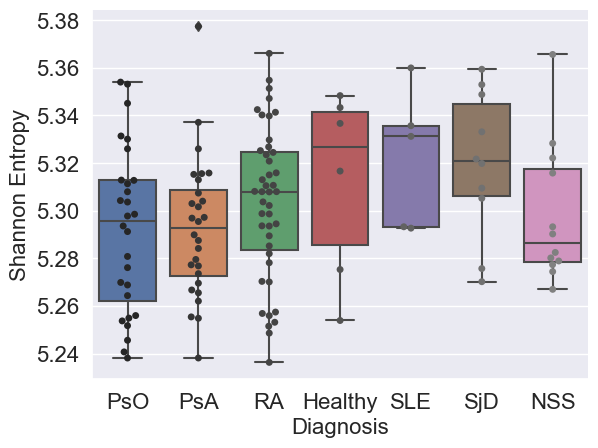

In [108]:
# plot nicer alpha div for pathways
df_alpha = pd.read_csv(path + 'outputs/jobs06/div/metadata.tsv', sep='\t')
df_alpha = df_alpha.iloc[1:,:]
df_alpha = df_alpha.set_index('id')

# convert to float
df_alpha['shannon_entropy'] = df_alpha['shannon_entropy'].map(lambda x: float(x)) 

# convert NSS to SICCA

# rename
pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SjD'),('healthy','Healthy')]     
for p in pairs:
    df_alpha['Diagnosis'] = df_alpha['Diagnosis'].replace(p[0],p[1])


# KW test
print(scipy.stats.kruskal(*list(df_alpha.groupby('Diagnosis')['shannon_entropy'].apply(list).values), nan_policy='propagate', axis=0, keepdims=False))

# do sns 
ax = sns.boxplot(data=df_alpha, x='Diagnosis', y='shannon_entropy')
sns.swarmplot(data=df_alpha, x='Diagnosis', y='shannon_entropy', palette='dark:grey', hue=None)

# ax.axes.set_title("Title",fontsize=48)
ax.set_ylabel("Shannon Entropy",fontsize=16)
ax.set_xlabel("Diagnosis",fontsize=16)
ax.tick_params(labelsize=16)
#plt.xticks(rotation=45)
sns.despine()
# plt.savefig(path + 'inputs/Qiime2_0_KB_batch/adiv.pdf')
df_alpha.to_csv(path + 'outputs/jobs06/df_alpha_pathway.tsv', sep='\t')
print(len(df_alpha))
df_alpha.Diagnosis.value_counts()


In [109]:
# process beta ordination for R plotting
df_pc = pd.read_csv(path + 'outputs/jobs06/div/ordination.txt', sep='\t', skiprows=9)

# set index to first sample and drop last two metadata rows
df_pc = df_pc.set_index('131-slesjo-plate308') 
df_pc = df_pc.iloc[:-2,:]

# create new row from column names and replace old col names
df_pc.loc['131-slesjo-plate308'] = df_pc.columns.values  # adding a row
df_pc.columns = ['PC' + str(i+1) for i in range(len(df_pc.columns))]
df_pc.index.name = 'SampleID'

# merge with metadata
df_pc = pd.concat([df_pc, df_meta, df_med], axis=1)

# rename
pairs = [('non-sjogrens sicca','NSS'), ('pso','PsO'), ('psa','PsA'), ('sle','SLE'), ('ss','SjD'),('healthy','Healthy')]
for p in pairs:
    df_pc['Diagnosis'] = df_pc['Diagnosis'].replace(p[0],p[1])

df_pc.to_csv(path + 'outputs/jobs06/unweighted_pcoa_pathway.tsv', sep='\t')
df_pc.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,DiseaseDurationYears,RFpos,Batch,EverTreated,Medication,DiseaseActive,AgeAtVisit,shannon_entropy,sum,Medication_Status
209-pso-plate307,-0.008881,-0.020698,0.000817,0.003947,-0.001745,-0.001427,-0.000896,0.006009,-0.004932,0.004023,...,30,NaN,CDP,NaN,NaN,NaN,NaN,4.841988,0.0,NoMed
235-psa-plate307,0.004836,-0.011235,0.009275,0.013553,0.008291,0.004627,-0.004695,-0.005961,-0.000831,-0.005894,...,NaN,NaN,CDP,NaN,NaN,NaN,NaN,3.696383,0.0,NoMed
240-psa-plate307,0.000593,-0.010171,0.003352,0.003098,0.004199,0.007475,-0.00472,0.000835,-0.001235,-0.004771,...,NaN,NaN,CDP,NaN,NaN,NaN,NaN,3.530011,0.0,NoMed
241-pso-plate307,-0.021517,0.052043,-0.014548,0.035343,-0.021066,-0.008324,-0.005262,0.002604,0.007773,-0.004614,...,NaN,NaN,CDP,NaN,NaN,NaN,NaN,3.115866,0.0,NoMed
260-pso-plate307,-0.027172,0.031436,-0.019064,-0.005124,0.024105,0.000973,0.004826,0.007214,-0.009212,-0.010919,...,35,NaN,CDP,NaN,NaN,NaN,NaN,4.924878,0.0,NoMed


##### Binning clinical severity #####

In [155]:
# disease severity clinical 
'''
SJC
AMP RA:  28 or 44 probably 28 and 28 for non AMP RA
PsO: 66
STAMP: 28
SLE NA

TJC
PsO 68 instead of 66 (hip joint)
Same as above 

RA
DAS28 / CRP or ESR
<=2.6 remission
(2.6-3.2] low
(3.2-5.1] moderate
>5.1

PsA
PhysicianGlobal? Ask Uri

PsO
BSA ask Uri 

SjD
ESSDAI per Sara >= 5 for moderate/severe disease 

SLE
SLEDAI?
<=3 no flares 
(3,12] mild moderate
>12 severe
'''
# df_meta, df_alpha
df_cs = pd.read_csv(path + 'inputs/ampaim_ds.csv', index_col=0)
df_cs.columns.values

# df_alpha, df_beta, L_to_otu

# interesting things to look into in df_cs
cs_col = ['p29_domain_function', 'p29_domain_anxiety', 'p29_domain_depression', 'p29_domain_fatigue',
 'das28_esr3-score', 'das28_esr4-score', 'das28_crp3-score','das28_crp4-score',
 'jc_swollen_total', 'jc_tender_total',
 'esspri_total-score',
 'essdai_score_copy', 'esspri_total-score_copy',
 'sledai_total-score',
 'pasi_total-severity', 'pasi_bsa_total-percent']

df_meta.columns.values # will eventually need to control for CurrentOtherDMARDs, prednisone, hcq, mtx, Sex

meta_col = ['Diagnosis','BSA','CRP','DAS28','ESR','SJC','TJC']

L_to_spec_otu['L6'].head()

,Phascolarctobacterium,Anaerotignum,Coprobacter,Clostridium,Akkermansia,Roseburia,Faecalibacterium,BSA,CRP,ESR,SJC,TJC,Diagnosis
131-slesjo-plate308,0.000000,0.000000,0.0,0.006220,0.114119,0.050744,0.012599,NaN,NaN,NaN,NaN,NaN,SjD
209-pso-plate307,0.022813,0.000264,0.0,0.000923,0.000000,0.000308,0.099209,3,NaN,10,0,2,PsO
235-psa-plate307,0.000000,0.004882,0.0,0.021295,0.243498,0.004798,0.000000,3,NaN,NaN,0,1,PsA
240-psa-plate307,0.008384,0.000000,0.0,0.008688,0.076671,0.000457,0.040317,13,NaN,NaN,0,7,PsA
241-pso-plate307,0.001458,0.000000,0.0,0.002089,0.000000,0.000552,0.000197,7,NaN,NaN,0,0,PsO


In [157]:
# convert indices to uniform values
df1 = df_meta.copy()
idx1 = df1.index.values

df2 = df_cs.copy()
idx2 = df2.index.unique().values # duplicate timepoints per subject

cs_to_meta = {}

for i in idx2:
    p1, p2 = i.split('-')

    for j in idx1:
        if p1 in j and p2 in j:
            # print(j)
            cs_to_meta[i] = j

# determine number of lost indices
df = df_cs[cs_col]
df.index = df.index.map(cs_to_meta)
df = df.drop(np.nan)
print(len(df))
df = df.dropna(how='all')
print(len(df))
# cast to numeric
df = df.astype(float)
df = df.groupby(df.index).mean() # doesn't work...
# take first instance
# df = df.drop_duplicates(keep='first')
print(len(df))
df_cs_spec = df.copy()
df_cs_spec.head()

47
25
24


,p29_domain_function,p29_domain_anxiety,p29_domain_depression,p29_domain_fatigue,das28_esr3-score,das28_esr4-score,das28_crp3-score,das28_crp4-score,jc_swollen_total,jc_tender_total,esspri_total-score,essdai_score_copy,esspri_total-score_copy,sledai_total-score,pasi_total-severity,pasi_bsa_total-percent
Subject,,,,,,,,,,,,,,,,
403.001.lockit.plate313,18.0,7.0,5.0,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
501.002.aimra.plate313,15.0,4.0,4.0,9.0,8.03,7.71,6.50,6.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501.003.aimra.plate313,16.0,12.0,12.0,20.0,6.58,6.64,5.31,5.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601.001.ellipss.plate313,20.0,9.0,9.0,14.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,5.7,10.0
601.002.ellipss.plate313,12.0,16.0,16.0,4.0,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,4.3,11.0


In [172]:
# perform binning
dx_to_mapping ={}

dx_to_mapping['RA'] = {
    'DAS28':[[0,2.6,3.2,5.1,1000],['remission','mild','moderate','severe']]
    #'das28_esr3-score':[[0,2.6,3.2,5.1,1000],['remission','mild','moderate','severe']]
} # store as metadata var key: bins, labels tuples as values
dx_to_mapping['NSS'] = {
    'das28_esr3-score':[[0,2.6,3.2,5.1,1000],['remission','mild','moderate','severe']]
} # store as metadata var key: bins, labels tuples as values
dx_to_mapping['PsA'] = {
    'PhysicianGlobalPsA':[[0,2,4,1000],['mild','moderate','severe']]
}
dx_to_mapping['PsO'] = {
    'BSA':[[0,3,10,1000],['mild','moderate','severe']]
    #'pasi_bsa_total-percent':[[0,3,10,1000],['mild','moderate','severe']]
}
dx_to_mapping['SjD'] = {
    'essdai_score_copy':[[0,1,5,1000],['mild','moderate','severe']]
}
dx_to_mapping['SLE'] = {
    'sledai_total-score':[[0,3,12,1000],['mild','moderate','severe']]
}

'''
SJC
AMP RA:  28 or 44 probably 28 and 28 for non AMP RA
PsO: 66
STAMP: 28
SLE NA

TJC
PsO 68 instead of 66 (hip joint)
Same as above 
'''
# df_alpha, df_beta, L_to_otu

# interesting things to look into in df_cs
cs_col = ['p29_domain_function', 'p29_domain_anxiety', 'p29_domain_depression', 'p29_domain_fatigue',
 'das28_esr3-score', 'das28_esr4-score', 'das28_crp3-score','das28_crp4-score',
 'jc_swollen_total', 'jc_tender_total',
 'esspri_total-score',
 'essdai_score_copy', 'esspri_total-score_copy',
 'sledai_total-score',
 'pasi_total-severity', 'pasi_bsa_total-percent']

df_meta.columns.values # will eventually need to control for CurrentOtherDMARDs, prednisone, hcq, mtx, Sex

meta_col = ['Diagnosis','BSA','CRP','DAS28','ESR','SJC','TJC']


# merge df
#df_merge = pd.concat([df_meta[meta_col], df_cs_spec],axis=1)
df_merge = pd.concat([df_cs_spec,df_meta[['PhysicianGlobalPsA','DAS28']],df_med[['Medication_Status','Medication_Status2']]],axis=1)

# combinen with df alpha and L_to_otu spec
df_merge = pd.concat([df_merge, df_alpha['shannon_entropy'], L_to_spec_otu['L6'], L_to_spec_otu['L7']['Prevotella_copri']],axis=1)

# rename dx
df_merge = rename_df(df_merge,'Diagnosis')

# drop na in microbiome
print(len(df_merge))
df_merge = df_merge.dropna(subset='shannon_entropy')
print(len(df_merge))

# create bins for each dx
subdfs = []
for d in dx:
    subdf = df_merge[df_merge['Diagnosis'] == d]
    if d == 'Healthy':
        subdf['severity'] = 'none'    
    else:
        for v in dx_to_mapping[d]:
            subdf[v] = subdf[v].astype(float)
            subdf['severity'] = pd.cut(subdf[v], bins = dx_to_mapping[d][v][0], labels = dx_to_mapping[d][v][1])
    subdfs.append(subdf)        

df_merge = pd.concat(subdfs)
print(len(df_merge))
#df['age_bins'] = pd.cut(df['age'], bins=bins, labels=labels)

df_merge['num_severity'] = df_merge['severity'].map({
    'none': 0,
    'remission': 1,
    'mild': 2,
    'moderate': 3,
    'severe': 4
})
df_merge.head()

#for c in cs_col:
#    print(df_merge[c].value_counts())

132
132
132


,p29_domain_function,p29_domain_anxiety,p29_domain_depression,p29_domain_fatigue,das28_esr3-score,das28_esr4-score,das28_crp3-score,das28_crp4-score,jc_swollen_total,jc_tender_total,...,Faecalibacterium,BSA,CRP,ESR,SJC,TJC,Diagnosis,Prevotella_copri,severity,num_severity
SCFA08-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.020075,NaN,NaN,NaN,NaN,NaN,Healthy,0.000000,none,0.0
MicraHC-1017-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.007565,NaN,NaN,NaN,NaN,NaN,Healthy,0.000063,none,0.0
MicraHC-1018-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.167786,NaN,NaN,NaN,NaN,NaN,Healthy,0.000000,none,0.0
MicraHC-1019-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.034748,NaN,NaN,NaN,NaN,NaN,Healthy,0.000000,none,0.0
MicraHC-1020-B-plate308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125057,NaN,NaN,NaN,NaN,NaN,Healthy,0.000000,none,0.0


In [162]:
# partition into aimd only and healthy df
df_aimd = df_merge[df_merge['Diagnosis'] != 'Healthy']
df = df_merge.copy()

cats = ['none','remission','mild','moderate','severe']

for m in ['shannon_entropy','Anaerotignum','Coprobacter','Clostridium','Akkermansia','Roseburia','Faecalibacterium','Phascolarctobacterium']:
    print(m)
    subdfs = []
    for s in cats:
        subdfs.append(df[df['severity']==s])
    
    f, p = scipy.stats.f_oneway(*[df[m] for df in subdfs])
    print(f,p)

    for h in ['Medication_Status2','Diagnosis']:
        plt.figure(figsize=(6,4))
        # sns.violinplot(data=df,x='severity',y=m, order=cats,hue=h) #hue='Diagnosis'
        sns.boxplot(data=df,x='severity',y=m, order=cats,hue=h, showfliers=False) #hue='Diagnosis'
        sns.stripplot(data=df,x='severity',y=m, order=cats,hue=h,dodge=True,legend=False,color='gray') #hue='Diagnosis'
        sns.despine()
        plt.savefig(path + 'outputs/jobs29/boxplot_' + m + '_' +  h + '_' + str(np.round(p,3)) + '.pdf')
        plt.close()

df.to_csv(path + 'inputs/df_glm_ds.tsv', sep='\t')

shannon_entropy
3.366524892248634 0.013052533376257492
Anaerotignum
0.7752193083358345 0.5442613376185366
Coprobacter
1.32773641883116 0.2660575575304255
Clostridium
2.114236512365365 0.08581168016875199
Akkermansia
1.4451991744167938 0.22598018805126588
Roseburia
1.5357498284087086 0.19890400146021103
Faecalibacterium
1.220496132979588 0.3080096634610147
Phascolarctobacterium
4.080336551868277 0.004445091596699496


In [139]:
# value counts of severity per disease
df_merge.groupby('Diagnosis')['severity'].value_counts()

Diagnosis  severity 
Healthy    none          6
NSS        remission     5
           moderate      5
           mild          2
PsA        severe        9
           moderate      4
           mild          1
PsO        mild         12
           moderate      7
           severe        1
RA         severe       24
           moderate      8
           mild          3
           remission     2
SLE        mild          1
SjD        moderate      2
Name: count, dtype: int64

##### Testing severity PERMANOVA #####

In [154]:
# PERMANOVA
# get unweighted unifrac dm

df = df_merge.copy()

import itertools
comps = list(itertools.combinations(cats, 2))
comps.append(['none','remission','mild','moderate','severe'])
print(comps)

m = 'severity'
import labtools.statistics

dm = pd.read_csv(path + 'inputs/Q2_MSQ138_141_noctrl_noeiser_nocd_correct/distance-matrix.tsv',sep='\t', index_col=0)
for c in comps:
    print(c)
    df = df_merge[df_merge['severity'].isin(c)]

    # grab order of samples
    dm_order = list(df.index.values)
    
    # grab order of metadata of interest
    # for m in ['Medication_Status', 'Diagnosis']:
    
    true_labels = df.loc[dm_order,m]
    # takes in distance matrix
    f, p = labtools.statistics.permanova_oneway(dm.loc[dm_order, dm_order], levels=list(true_labels))
    print(f, p)

    # pcoa plot
    df_pcoa = pd.concat([df,df_pc[['PC1','PC2']]],axis=1)
    df_pcoa = df_pcoa[['Medication_Status2','Diagnosis','severity','PC1','PC2']]
    df_pcoa = df_pcoa.loc[dm_order,:]
    
    for h in ['Medication_Status2','Diagnosis']:
        plt.figure(figsize=(6,4))
        # sns.violinplot(data=df,x='severity',y=m, order=cats,hue=h) #hue='Diagnosis'
        sns.scatterplot(data=df_pcoa,x='PC1',y='PC2',hue='severity',style=h) #hue='Diagnosis'
        sns.despine()
        plt.savefig(path + 'outputs/jobs29/pcoa_' + m + '_' +  h + '_' + str(np.round(p,3)) + '_' + str(c) + '.pdf')
        plt.close()
    

dm.head()

[('none', 'remission'), ('none', 'mild'), ('none', 'moderate'), ('none', 'severe'), ('remission', 'mild'), ('remission', 'moderate'), ('remission', 'severe'), ('mild', 'moderate'), ('mild', 'severe'), ('moderate', 'severe'), ['none', 'remission', 'mild', 'moderate', 'severe']]
('none', 'remission')
1.4042576992973757 0.065
('none', 'mild')
-4.260502701921118 0.34
('none', 'moderate')
-8.293988164885945 0.63
('none', 'severe')
-12.454529242105236 0.66
('remission', 'mild')
-3.4635487745994054 0.33
('remission', 'moderate')
-7.43245697179434 0.615
('remission', 'severe')
-11.498044544719246 0.46
('mild', 'moderate')
-0.5571209367085137 0.945
('mild', 'severe')
-3.457739683756145 0.755
('moderate', 'severe')
-0.09879375779688176 0.545
['none', 'remission', 'mild', 'moderate', 'severe']
-5.2244153829371385 0.725


,131-slesjo-plate308,209-pso-plate307,235-psa-plate307,240-psa-plate307,241-pso-plate307,260-pso-plate307,272-psa-plate307,2771-slesjo-plate308,2876-slesjo-plate308,288-psa-plate307,...,703.001.stamp.plate313,703.005.stamp.plate313,703.006.stamp.plate313,703.008.stamp.plate313,703.009.stamp.plate313,703.010.stamp.plate313,703.011.stamp.plate313,703.013.stamp.plate313,703.016.stamp.plate313,703.019.stamp.plate313
131-slesjo-plate308,0.000000,0.406189,0.450703,0.397154,0.512140,0.532803,0.405327,0.518795,0.411360,0.383650,...,0.440699,0.392726,0.449724,0.434453,0.442443,0.486144,0.351876,0.458182,0.407761,0.415931
209-pso-plate307,0.406189,0.000000,0.450687,0.355725,0.455935,0.488601,0.426432,0.519001,0.425610,0.397909,...,0.341917,0.457835,0.371972,0.453595,0.405416,0.431912,0.350309,0.485079,0.447852,0.376363
235-psa-plate307,0.450703,0.450687,0.000000,0.421108,0.526019,0.601446,0.545655,0.487553,0.506510,0.448764,...,0.484023,0.447653,0.510536,0.526474,0.508758,0.462404,0.442704,0.498408,0.460242,0.501350
240-psa-plate307,0.397154,0.355725,0.421108,0.000000,0.514477,0.539822,0.393483,0.506790,0.467719,0.440561,...,0.427407,0.488324,0.442264,0.445184,0.485809,0.423217,0.386523,0.482401,0.392273,0.417038
241-pso-plate307,0.512140,0.455935,0.526019,0.514477,0.000000,0.592731,0.515258,0.606789,0.560403,0.455650,...,0.543589,0.494251,0.499379,0.534638,0.501184,0.570054,0.472412,0.547915,0.526438,0.508315


##### Specific pathway analyses #####

In [188]:
# iron and vitamin b pathways
df = pd.concat([df_merge, df_fxn],axis=1)
# df = df[df['Diagnosis'] != 'Healthy']

queries = ['folate','vitamin','Porphyrin','transport']
for x in df.columns.values:
    for q in queries:
        if q in x:
            print(x)

int_var = ['Metabolism|Metabolism of cofactors and vitamins|Folate biosynthesis',
           'Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate',
          'Environmental Information Processing|Membrane transport|ABC transporters',
          'Metabolism|Metabolism of cofactors and vitamins|Porphyrin metabolism']

for v in int_var:
    a = df[v]
    b = df['num_severity']
    r,p=scipy.stats.spearmanr(a,b,nan_policy='omit')
    print(v)
    print(r,p)
    

Metabolism|Metabolism of cofactors and vitamins
Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism
Metabolism|Metabolism of cofactors and vitamins|Pantothenate and CoA biosynthesis
Metabolism|Metabolism of cofactors and vitamins|Biotin metabolism
Metabolism|Metabolism of cofactors and vitamins|Riboflavin metabolism
Metabolism|Metabolism of cofactors and vitamins|Vitamin B6 metabolism
Metabolism|Metabolism of cofactors and vitamins|Nicotinate and nicotinamide metabolism
Metabolism|Metabolism of cofactors and vitamins|Lipoic acid metabolism
Metabolism|Metabolism of cofactors and vitamins|Porphyrin metabolism
Metabolism|Metabolism of cofactors and vitamins|Porphyrin metabolism
Metabolism|Metabolism of cofactors and vitamins|Folate biosynthesis
Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate
Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate
Human Diseases|Drug resistance: antineoplastic|Antifolate resistance
Metabolism|Metab

<Axes: xlabel='num_severity', ylabel='Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate'>

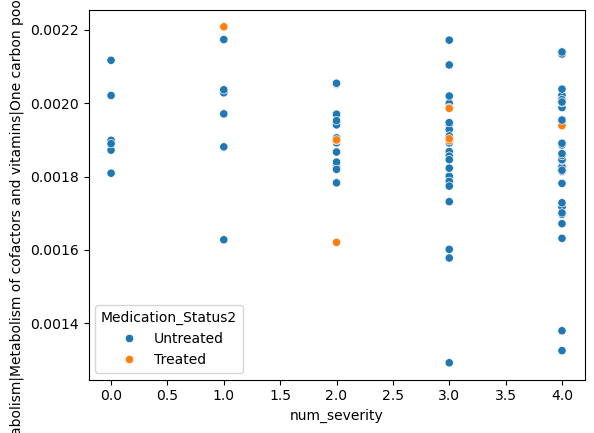

In [189]:
sns.scatterplot(y='Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate',x='num_severity',data=df,hue='Medication_Status2')

In [ ]:
scipy.stats.ttest(df[df['Diagnosis'] == 'Healthy'][''Metabolism|Metabolism of cofactors and vitamins|One carbon pool by folate']

In [ ]:
# pathway mapping
df_ko = pd.read_csv(path + 'outputs/jobs06/picrust2_out/KO_metagenome_out/pred_metagenome_unstrat.tsv', sep='\t', index_col=0).T

# database
df_db = pd.read_csv(path + 'inputs/ko.txt', sep='\t',header=None)
df_db.columns = ['KO','Protein']
# df_db.to_dict()
KO_to_p = df_db.set_index('KO').to_dict()['Protein']
p_to_KO = df_db.set_index('Protein').to_dict()['KO']

# int ko

In [210]:
# dihydrofolate reductase (EC 1.5.1.3)
# Precorrin-6A reductase (EC 1.2.1.54)
queries = ['1.5.1.3]', '1.2.1.54]']
for p in p_to_KO:
    for q in queries:
        if q in p:
            print(p)
# p_to_KO

DHFR, folA; dihydrofolate reductase [EC:1.5.1.3]
folM; dihydromonapterin reductase / dihydrofolate reductase [EC:1.5.1.50 1.5.1.3]
dfrA1, dhfr; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrA12, dhfr; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrD, dhfr; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrA10, dfr10; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrA19, dfrA18; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]
dfrB, dfr2; dihydrofolate reductase (trimethoprim resistance protein) [EC:1.5.1.3]


In [237]:
p_to_queries = {'B9': ['dihydrofolate reductase',
                      '5-formyltetrahydrofolate cyclo-ligase',
                      'Formyltetrahydrofolate',
                      'N10-formyl-tetra-hydrofolate biosynthesis'],
                'B12': ['precorrin-5B',
                       'Adenosylcobinamide']}

p_to_p = {}

for p in p_to_queries: # e.g. B9
    print('\n')
    print('New Group: ' + p)
    p_to_p[p] = {}
    for t in p_to_queries[p]: # e.g. Dihydrofolate
        print('Query: ' + t)
        print('\n')
        p_to_p[p][t] = []
        for k in p_to_KO: # the entire database to KO mapping
            if t in k:
                p_to_p[p][t].append(k)
        if len(p_to_p[p][t]) == 0:
            print(t)





New Group: B9
Query: dihydrofolate reductase


Query: 5-formyltetrahydrofolate cyclo-ligase


Query: Formyltetrahydrofolate


Formyltetrahydrofolate
Query: N10-formyl-tetra-hydrofolate biosynthesis


N10-formyl-tetra-hydrofolate biosynthesis


New Group: B12
Query: precorrin-5B


Query: Adenosylcobinamide


Adenosylcobinamide
